In [2]:
# Importing the necessary libraries for the project. 
import pandas as pd 
import yfinance as yf
import numpy as np # for numerical operations
import seaborn as sns #visualisation
import matplotlib.pyplot as plt # visualization
%matplotlib inline 
import matplotlib.ticker as ticker # Library to customize ticks
from datetime import date
import matplotlib.dates as mdates
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from math import sqrt
# ParameterSampler for randomized hyperparameter sampling, optimizing model parameters in cross-validation.
from sklearn.model_selection import ParameterSampler
# pmdarima's auto_arima for automated selection of the best ARIMA parameters based on AIC/BIC scores.
from pmdarima import auto_arima
# TimeSeriesSplit for cross-validation with time series data to preserve the temporal ordering of data.
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
# Mean Squared Error and Mean Absolute Error metrics from sklearn for evaluating model accuracy.
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterSampler
from tensorflow.keras.optimizers import Adam
from keras.layers import BatchNormalization, Dropout, Dense, LSTM, GRU
import random
import optuna
from optuna.samplers import TPESampler
from keras_tuner import BayesianOptimization

import warnings # filter warnings
warnings.filterwarnings('ignore')

In [3]:
# Importing the dataset after the Log Returns transformation.
df1 = pd.read_csv('df1.csv', index_col=0, parse_dates=True)

# Along with the importation, the code will set the date as the index, value of 0 because is the first column.
## Setting parse_dates=true to ensure the dates are in datetime, making more appropriate for ML models.

In [4]:
df1.head()

,Close,lag_1,lag_4,rolling_mean_4w,rolling_mean_12w,volatility_4w
Date,,,,,,
2004-04-01,0.012635,0.031461,-0.023861,0.003674,0.000735,117.596902
2004-04-08,-0.010896,0.012635,-0.000125,0.000981,-0.001424,117.741650
2004-04-15,-0.003623,-0.010896,-0.029274,0.007394,-0.000325,0.776477
2004-04-22,-0.001496,-0.003623,0.031461,-0.000845,-0.000305,0.623353
2004-04-29,-0.000784,-0.001496,0.012635,-0.004200,-0.002649,0.647610


In [5]:
df1.describe()

,Close,lag_1,lag_4,rolling_mean_4w,rolling_mean_12w,volatility_4w
count,1031.000000,1031.000000,1031.000000,1031.000000,1031.000000,1031.000000
mean,0.001575,0.001608,0.001508,0.001578,0.001516,7.731465
std,0.020723,0.020744,0.020750,0.009796,0.005364,23.505939
min,-0.069935,-0.069935,-0.069935,-0.051352,-0.026288,0.154122
25%,-0.007633,-0.007633,-0.007858,-0.003032,-0.001013,1.538535
50%,0.003635,0.003666,0.003626,0.002937,0.002346,2.585030
75%,0.013568,0.013643,0.013514,0.007596,0.004979,6.157669
max,0.051947,0.051947,0.051947,0.031089,0.019145,338.128664


In [6]:
# Define the selected exogenous variables
ex1 = df1[['rolling_mean_4w', 'rolling_mean_12w', 'volatility_4w', 'lag_1', 'lag_4']]

In [7]:
# Define the split index for the train-test split (85% train, 15% test)
split_index = int(0.85 * len(df1))

# Target variable split
train = df1['Close'][:split_index]
test = df1['Close'][split_index:]

# Exogenous variables split
exo_train = ex1[['rolling_mean_4w', 'rolling_mean_12w', 'volatility_4w', 'lag_1', 'lag_4']][:split_index]
exo_test = ex1[['rolling_mean_4w', 'rolling_mean_12w', 'volatility_4w', 'lag_1', 'lag_4']][split_index:]

## model - order=(1, 0, 3), seasonal_order=(1, 0, 2, 52) 
- p/d/q order extracted from the best parameters from the SARIMAX notebook.
- The parameters are the same as the baseline model (Best accuracy metrics across 4 different seasonalities).

                                        SARIMAX Results                                        
Dep. Variable:                                   Close   No. Observations:                  876
Model:             SARIMAX(1, 0, 3)x(1, 0, [1, 2], 52)   Log Likelihood                2537.512
Date:                                 Sun, 01 Dec 2024   AIC                          -5049.025
Time:                                         14:24:11   BIC                          -4986.945
Sample:                                     04-01-2004   HQIC                         -5025.279
                                          - 01-07-2021                                         
Covariance Type:                                   opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rolling_mean_4w      1.4156      0.097     14.645      0.000  

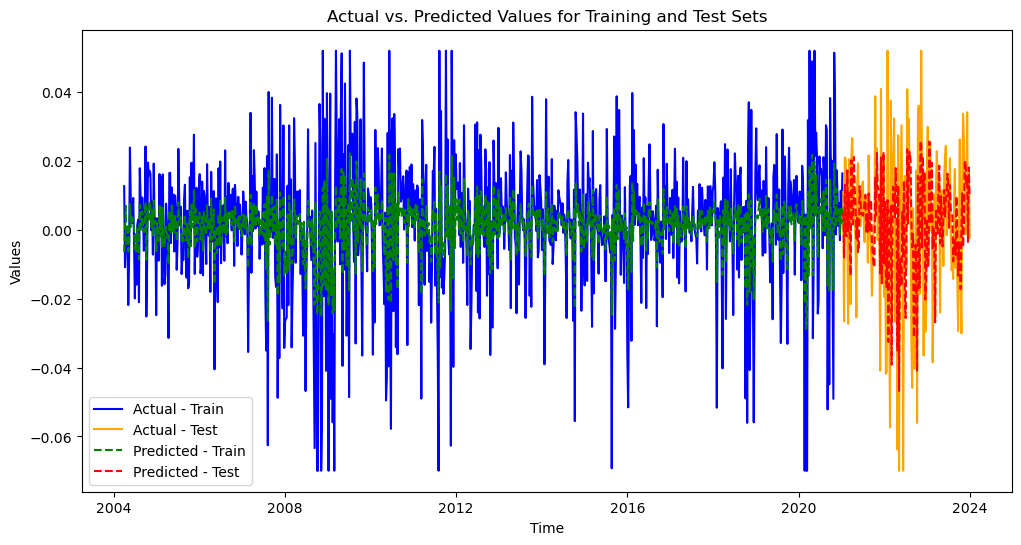

In [14]:
# Define SARIMAX model.
sarimax_model = SARIMAX(train, order=(1, 0, 3), seasonal_order=(1, 0, 2, 52), exog=exo_train)
sarimax_final_52 = sarimax_model.fit(disp=False)

# Print summary.
print(sarimax_final_52.summary())

# Calculate RMSE on training data.
train_predictions = sarimax_final_52.predict(start=0, end=len(train)-1, exog=exo_train)
train_rmse = mean_squared_error(train, train_predictions, squared=False)

# Calculate MAE on training data.
train_mae = mean_absolute_error(train, train_predictions)

# Calculate RMSE on test data.
test_predictions = sarimax_final_52.forecast(steps=len(test), exog=exo_test)
test_rmse = mean_squared_error(test, test_predictions, squared=False)

# Calculate MAE on test data.
test_mae = mean_absolute_error(test, test_predictions)

# Calculate Directional Accuracy on Training Data.
train_direction_accuracy = np.mean(
    np.sign(train_predictions[:-1] - train_predictions[1:]) == np.sign(train[:-1] - train[1:]))

# Calculate Directional Accuracy on Test Data.
test_direction_accuracy = np.mean(
    np.sign(test_predictions[:-1] - test_predictions[1:]) == np.sign(test[:-1] - test[1:]))

# Print evaluation metrics.
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_direction_accuracy * 100:.2f}%")
print(f"Directional Accuracy on Test Data: {test_direction_accuracy * 100:.2f}%")

# Plot the actual vs. predicted values for training and test sets.
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on training and test set.
plt.plot(train.index, train_predictions, label="Predicted - Train", linestyle='--', color='green')
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot.
plt.legend()
plt.title("Actual vs. Predicted Values for Training and Test Sets")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

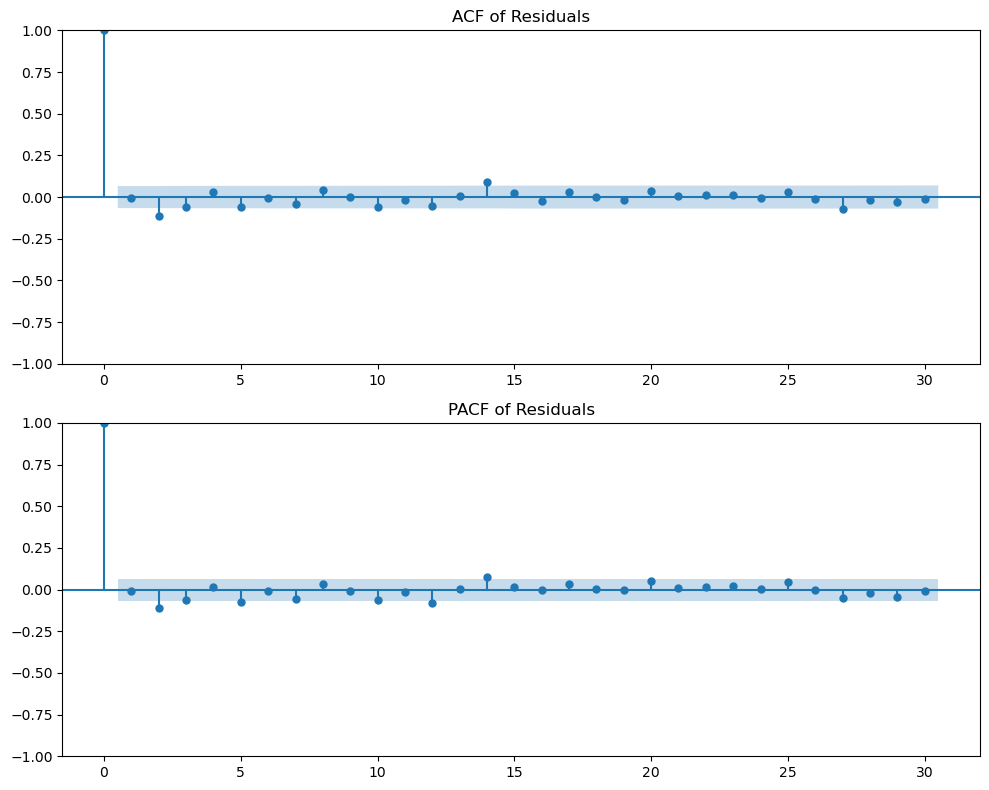

In [15]:
# Calculate residuals from the fitted model.
residuals_52 = sarimax_final_52.resid

# Plot ACF and PACF for residuals.
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
sm.graphics.tsa.plot_acf(residuals_52, lags=30, ax=ax[0])
ax[0].set_title('ACF of Residuals')
sm.graphics.tsa.plot_pacf(residuals_52, lags=30, ax=ax[1])
ax[1].set_title('PACF of Residuals')
plt.tight_layout()
plt.show()

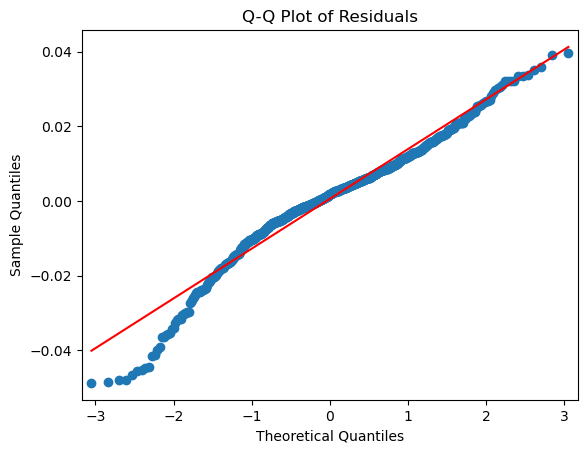

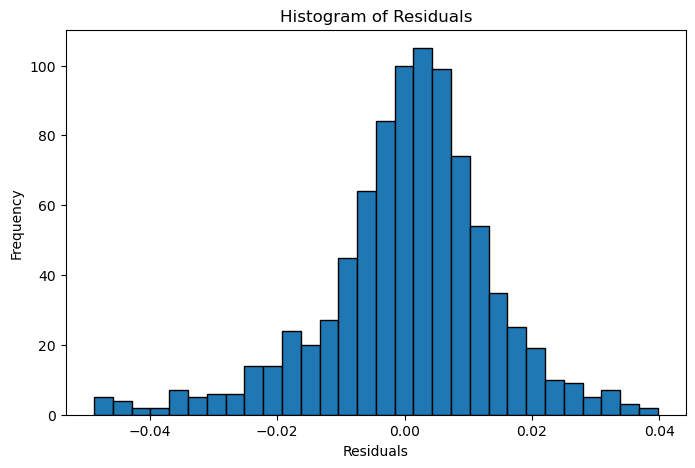

In [16]:
# Q-Q plot for normality check.
sm.qqplot(residuals_52, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

# Histogram of residuals.
plt.figure(figsize=(8, 5))
plt.hist(residuals_52, bins=30, edgecolor='k')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

In [17]:
# Ljung-Box test for autocorrelation.
ljung_box_results = acorr_ljungbox(residuals_52, lags=[10, 20, 30], return_df=True)
print(ljung_box_results) # prints the results.

# Arch test for heteroscedasticity 
arch_test_stat, arch_pvalue, _, _ = het_arch(residuals_52)
print("ARCH Test p-value:", arch_pvalue) # prints the arch results

      lb_stat  lb_pvalue
10  24.333845   0.006762
20  37.871745   0.009181
30  44.706827   0.041094
ARCH Test p-value: 7.96929136614076e-24


In [18]:
residuals_52.describe()

count    876.000000
mean       0.000569
std        0.013350
min       -0.048768
25%       -0.005453
50%        0.001800
75%        0.008253
max        0.039730
dtype: float64

- PREPING THE RESIDUALS

In [20]:
# Split data into training and testing sets, same ratio applied in SARIMAX.
train_size = int(0.85 * len(residuals_52))
y_train = residuals_52[:train_size]
y_test = residuals_52[train_size:]

scaler = StandardScaler()
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))

# Scale test residuals using the same scaler
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

# Print minimum and maximum values of the scaled training and test data for verification.
print("Scaled Training Residuals - Min:", y_train_scaled.min(), "Max:", y_train_scaled.max())
print("Scaled Test Residuals - Min:", y_test_scaled.min(), "Max:", y_test_scaled.max())

Scaled Training Residuals - Min: -3.814437916421522 Max: 3.051591283630084
Scaled Test Residuals - Min: -3.792881101513416 Max: 2.5610640174098926


## Sequence Length = 4

In [156]:
# Reshape residual data into sequences for LSTM.
sequence_length = 4  # Number of time steps used for target prediction.

# Initialize empty lists for the training set.
X_train_seq, y_train_seq = [], []
# Loop through the scaled training residuals to create sequences and targets.
for i in range(len(y_train_scaled) - sequence_length):
    X_train_seq.append(y_train_scaled[i:i + sequence_length])  # Sequence of past residuals.
    y_train_seq.append(y_train_scaled[i + sequence_length])    # Next residual value as target.

# Initialize empty lists for the test set.
X_test_seq, y_test_seq = [], []
# Loop through the scaled test residuals to create sequences and targets.
for i in range(len(y_test_scaled) - sequence_length):
    X_test_seq.append(y_test_scaled[i:i + sequence_length])  # Sequence of past residuals.
    y_test_seq.append(y_test_scaled[i + sequence_length])    # Next residual value as target.

# Convert lists to numpy arrays to use in LSTM model.
X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)

# Print the reshaped input and target data shapes for verification.
print(f"Reshaped X_train_seq shape: {X_train_seq.shape}")  
print(f"Reshaped y_train_seq shape: {y_train_seq.shape}")  
print(f"Reshaped X_test_seq shape: {X_test_seq.shape}")    
print(f"Reshaped y_test_seq shape: {y_test_seq.shape}")   

Reshaped X_train_seq shape: (740, 4, 1)
Reshaped y_train_seq shape: (740, 1)
Reshaped X_test_seq shape: (128, 4, 1)
Reshaped y_test_seq shape: (128, 1)


### Random Search with Optuna

In [32]:
# Set global random state for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Optuna's TPESampler with a fixed random seed for reproducibility in parameter search.
sampler = TPESampler(seed=random_seed)

# Create an Optuna study with direction "minimize" to minimize the validation loss.
study = optuna.create_study(direction="minimize", sampler=sampler)

# Define the objective function for hyperparameter optimization.
def lstm_objective(trial):
    """
    Objective function for Optuna to optimize hyperparameters of a LSTM model.
    This version uses residuals only, without additional features.
    """

    # Define hyperparameters to tune.
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.4, step=0.1)  # Dropout rate for LSTM layers.
    recurrent_dropout = trial.suggest_categorical("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout rate.
    l2_lambda = trial.suggest_loguniform("l2_lambda", 1e-3, 1e-1)  # L2 regularization factor.
    learning_rate = trial.suggest_categorical("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate for the optimizer.
    learning_rate_decay = trial.suggest_categorical("learning_rate_decay", [1e-6, 1e-5, 0])  # Learning rate decay.
    clipnorm = trial.suggest_categorical("clipnorm", [1.0, 5.0])  # Gradient clipping norm.
    units = trial.suggest_categorical("units", [32, 64, 128])  # Number of units in LSTM layers.
    num_layers = trial.suggest_int("num_layers", 1, 3)  # Number of LSTM layers.
    epochs = trial.suggest_int("epochs", 50, 200, step=50)  # Number of epochs.
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 120, 256])  # Batch size.

    # Initialize the Sequential model.
    model = Sequential()

    # Add LSTM layers based on num_layers.
    for i in range(num_layers):
        # Set return_sequences=True for all but the last LSTM layer.
        return_sequences = (i < num_layers - 1)
        
        # Add LSTM layer with specified hyperparameters.
        model.add(LSTM(
            units=units,
            return_sequences=return_sequences,
            input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,  # Input shape only for the first layer.
            kernel_regularizer=l2(l2_lambda),
            recurrent_dropout=recurrent_dropout
        ))

        # Add BatchNormalization and Dropout after each LSTM layer.
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    # Add the output layer with a single unit (regression).
    model.add(Dense(1))

    # Initialize the optimizer with learning rate, decay, and gradient clipping norm.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)

    # Compile the model with mean squared error loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Early stopping callback to avoid overfitting.
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model with given hyperparameters.
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test_seq, y_test_seq),
        shuffle=False,
        callbacks=[early_stopping],
        verbose=0  # Set verbose=0 to suppress training logs for faster experimentation.
    )

    # Retrieve the minimum validation loss from the training history.
    val_loss = min(history.history['val_loss'])
    
    # Return the validation loss to be minimized by Optuna.
    return val_loss

# Run the Optuna study for a given number of trials.
study.optimize(lstm_objective, n_trials=30)

# Print the best parameters found by the study.
print("Best hyperparameters:", study.best_params)

# Print the best validation loss achieved with the optimal parameters.
print("Best validation loss:", study.best_value)

[I 2024-11-26 13:54:26,121] A new study created in memory with name: no-name-b9f47429-e8f6-4af9-b2fb-87e78d508348
[I 2024-11-26 13:54:32,289] Trial 0 finished with value: 1.887722373008728 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.0037550037026405905, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 3, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 1.887722373008728.
[I 2024-11-26 13:54:38,072] Trial 1 finished with value: 3.692657947540283 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.04641587067816149, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 2, 'epochs': 50, 'batch_size': 256}. Best is trial 0 with value: 1.887722373008728.
[I 2024-11-26 13:54:48,671] Trial 2 finished with value: 3.5159356594085693 and parameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0.2, 

Best hyperparameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0.1, 'l2_lambda': 0.001047148538910998, 'learning_rate': 0.001, 'learning_rate_decay': 0, 'clipnorm': 5.0, 'units': 64, 'num_layers': 1, 'epochs': 150, 'batch_size': 120}
Best validation loss: 0.8729591965675354


In [176]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 64,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.001,
    'l2_lambda': 0.001047148538910998,
    'epochs': 150,
    'dropout_rate': 0.4,
    'clipnorm': 5.0,
    'batch_size': 120
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=False, 
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 1.3302 - val_loss: 0.8828
Epoch 2/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2965 - val_loss: 0.8833
Epoch 3/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3605 - val_loss: 0.8803
Epoch 4/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2353 - val_loss: 0.8802
Epoch 5/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2416 - val_loss: 0.8804
Epoch 6/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1987 - val_loss: 0.8779
Epoch 7/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1320 - val_loss: 0.8772
Epoch 8/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1155 - val_loss: 0.8765
Epoch 9/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1343 - val_loss: 0.8765
Epoch 10/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2176 - val_loss: 0.8764
Epoch 11/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1424 - val_loss: 0.8772
Epoch 12/150
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0634 - val_loss: 0.8788

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
LSTM Model Performance:
Training RMSE: 0.012861387091932824
Test RMSE: 0.015764789717675882
Training MAE: 0.009351422706073741
Test MAE: 0.01196766050067636
Directional Accuracy on Training Data: 64.41136671177267%
Directional Accuracy on Test Data: 67.71653543307087%


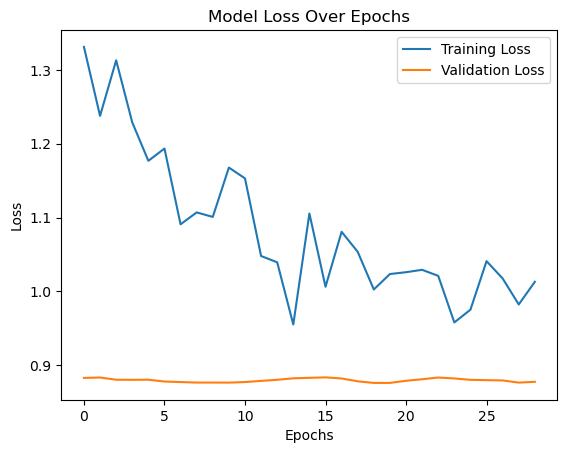

In [163]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Keras Tuner

In [153]:
# Set a global random seed for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Build LSTM model function with hyperparameter choices.
def build_lstm_model_tuner(hp):
    """
    Build an LSTM model for KerasTuner to optimize. Uses only residual sequences for input.
    """

    model = Sequential()

    # Define hyperparameters using `hp` for tuning options.
    dropout_rate = hp.Choice("dropout_rate", [0.2, 0.3, 0.4])  # Dropout rates.
    recurrent_dropout = hp.Choice("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout.
    l2_lambda = hp.Float("l2_lambda", min_value=0.001, max_value=0.1, sampling="log")  # L2 regularization.
    learning_rate = hp.Choice("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate.
    learning_rate_decay = hp.Choice("learning_rate_decay", [1e-5, 0.0])  # Learning rate decay.
    clipnorm = hp.Choice("clipnorm", [1.0, 5.0])  # Gradient clipping norm.
    units = hp.Choice("units", [32, 64, 128])  # Number of units in LSTM layers.
    num_layers = hp.Int("num_layers", 1, 3)  # Number of LSTM layers.
    batch_size = hp.Choice("batch_size", [32, 64, 120, 256])  # Batch size.

    # Add LSTM layers based on the number of layers selected.
    for i in range(num_layers):
        return_sequences = (i < num_layers - 1)  # Return sequences for intermediate layers only.
        model.add(LSTM(
            units=units,
            return_sequences=return_sequences,
            input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,
            kernel_regularizer=l2(l2_lambda),
            recurrent_dropout=recurrent_dropout
        ))
        model.add(BatchNormalization())  # Batch normalization to stabilize training.
        model.add(Dropout(dropout_rate))  # Dropout to combat overfitting.

    # Add the output layer (regression).
    model.add(Dense(1))

    # Configure optimizer with learning rate, decay, and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)

    # Compile the model.
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Print hyperparameters for debugging.
    print(f"Built model with params: dropout_rate={dropout_rate}, recurrent_dropout={recurrent_dropout}, "
          f"l2_lambda={l2_lambda}, learning_rate={learning_rate}, learning_rate_decay={learning_rate_decay}, "
          f"clipnorm={clipnorm}, units={units}, num_layers={num_layers}, batch_size={batch_size}")

    return model


# Set up Bayesian Optimization tuner to search for optimal hyperparameters.
tuner = BayesianOptimization(
    build_lstm_model_tuner,  # Model-building function.
    objective="val_loss",  # Target metric for optimization.
    max_trials=30,  # Maximum number of trials to run.
    executions_per_trial=1,  # Number of executions per trial.
    directory="sarimax-lstm",  # Directory to store tuning results.
    project_name="sarimax-lstm",  # Project name for the tuner.
    overwrite=True  # Overwrite previous tuner results if they exist.
)

# Define early stopping to prevent overfitting.
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Perform the hyperparameter search using the residuals (no features).
tuner.search(
    X_train_seq, y_train_seq,  # Training sequences and targets.
    validation_data=(X_test_seq, y_test_seq),  # Validation sequences and targets.
    epochs=200,  # Max number of epochs for each trial.
    callbacks=[early_stopping],  # Early stopping to avoid overfitting.
    shuffle=False,  # Ensure the time series order is preserved.
    verbose=1  # Show progress for each trial.
)

# Retrieve the best model and hyperparameters from the tuner.
best_lstm_model = tuner.get_best_models(num_models=1)[0]
best_lstm_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters found by KerasTuner.
print("Best hyperparameters for LSTM:", best_lstm_hyperparameters.values)
print("Best batch size for LSTM:", best_lstm_hyperparameters.get("batch_size"))

Trial 30 Complete [00h 00m 04s]
val_loss: 1.4924004077911377

Best val_loss So Far: 1.4867308139801025
Total elapsed time: 00h 05m 12s
Built model with params: dropout_rate=0.4, recurrent_dropout=0.2, l2_lambda=0.004687701723470747, learning_rate=0.0001, learning_rate_decay=1e-05, clipnorm=1.0, units=32, num_layers=1, batch_size=64
Best hyperparameters for LSTM: {'dropout_rate': 0.4, 'recurrent_dropout': 0.2, 'l2_lambda': 0.004687701723470747, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 1, 'batch_size': 64}
Best batch size for LSTM: 64


In [158]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.0001,
    'l2_lambda': 0.004687701723470747,
    'epochs': 120,
    'dropout_rate': 0.4,
    'clipnorm': 1.0,
    'batch_size': 64
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/120
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 2.1174 - val_loss: 1.5164
Epoch 2/120
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.1185 - val_loss: 1.5149
Epoch 3/120
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1254 - val_loss: 1.5134
Epoch 4/120
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8716 - val_loss: 1.5120
Epoch 5/120
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8206 - val_loss: 1.5107
Epoch 6/120
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5373 - val_loss: 1.5096
Epoch 7/120
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5664 - val_loss: 1.5087
Epoch 8/120
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6171 - val_loss: 1.5081
Epoch 9/120
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6386 - val_loss: 1.5078
Epoch 10/120
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4237 - val_loss: 1.5075
Epoch 11/120
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2970 - val_loss: 1.5075
Epoch 12/120
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
LSTM Model Performance:
Training RMSE: 0.012864788156939774
Test RMSE: 0.015774772264942283
Training MAE: 0.009352044702388927
Test MAE: 0.011963984832491076
Directional Accuracy on Training Data: 68.06495263870094%
Directional Accuracy on Test Data: 64.56692913385827%


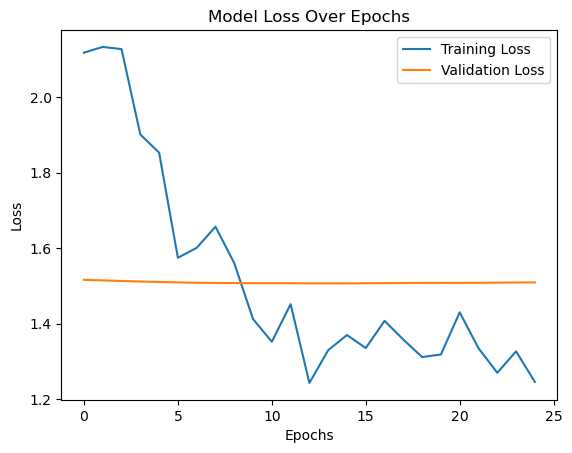

In [159]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Random Search with 2 Layers

In [35]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid for random hyperparameter search.
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],               # Dropout rate for regularization.
    'recurrent_dropout': [0.1, 0.2],               # Recurrent dropout within LSTM layers.
    'l2_lambda': [0.001, 0.01, 0.1],               # L2 regularization strength.
    'learning_rate': [0.001, 0.0005, 0.0001],      # Learning rate for optimizer.
    'learning_rate_decay': [1e-6, 1e-5, 0],        # Decay rate for learning rate over time.
    'units1': [32, 64, 128],                       # Number of units in the first LSTM layer.
    'units2': [32, 64, 128],                       # Number of units in the second LSTM layer.
    'batch_size': [32, 64, 120, 256],              # Batch size for training.
    'epochs': [50, 100, 200],                      # Number of epochs to train.
    'optimizer': ['adam'],                         # Optimizer to use.
    'clipnorm': [1.0, 5.0]                         # Gradient clipping to avoid exploding gradients.
}

# Generate a list of random combinations of hyperparameters.
n_iter_search = 30  # Number of random combinations to attempt.
# Random state being applied for reproducibility. 
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42)) 

# Define a function to build the LSTM model with given parameters.
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, optimizer_name, loss_function):
    model = Sequential()
    
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape based on sequence data.
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())  # Batch normalization for stable training.
    model.add(Dropout(dropout_rate))  # Dropout for regularization.
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units2, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer with a single unit for regression output.
    model.add(Dense(1))
    
    # Select optimizer with learning rate decay and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile the model with the chosen optimizer and loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Define early stopping to stop training when validation loss does not improve.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to store results of each model configuration.
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.01, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 5.0, 'batch_size': 64}
Final Training Loss: 1.3935681581497192
Final Validation Loss: 1.8255420923233032
Running combination 2/30: {'units2': 128, 'units1': 64, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.001, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 1.8348946571350098
Final Validation Loss: 2.027547836303711
Running combination 3/30: {'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 1.0, 'batch_size': 64}
Final Training Loss: 1.322214961051941
Final Validation Loss: 1.6686185598373413
Running combination 4/

In [166]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 128,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-06,
    'learning_rate': 0.001,
    'l2_lambda': 0.001,
    'epochs': 200,
    'dropout_rate': 0.4,
    'clipnorm': 1.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=False, 
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 2.9777 - val_loss: 1.5764
Epoch 2/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3130 - val_loss: 1.5644
Epoch 3/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0676 - val_loss: 1.5646
Epoch 4/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.9319 - val_loss: 1.5608
Epoch 5/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8595 - val_loss: 1.5686
Epoch 6/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6520 - val_loss: 1.5663
Epoch 7/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6520 - val_loss: 1.5716
Epoch 8/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5451 - val_loss: 1.5742
Epoch 9/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4955 - val_loss: 1.5702
Epoch 10/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4928 - val_loss: 1.5786
Epoch 11/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4107 - val_loss: 1.5731
Epoch 12/200
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
LSTM Model Performance:
Training RMSE: 0.012888241757746175
Test RMSE: 0.01578670077604734
Training MAE: 0.00936384535363532
Test MAE: 0.01198822420495584
Directional Accuracy on Training Data: 53.179972936400546%
Directional Accuracy on Test Data: 55.90551181102362%


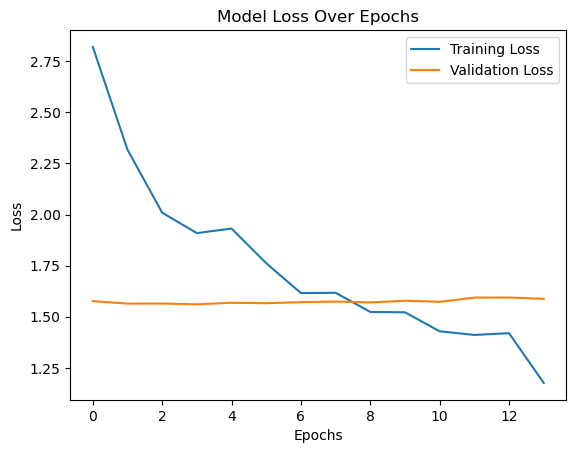

In [167]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Random Search with 3 Layers

In [36]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],
    'recurrent_dropout': [0.1, 0.2],
    'l2_lambda': [0.001, 0.01, 0.1],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'learning_rate_decay': [1e-6, 1e-5, 0],
    'units1': [32, 64, 128],
    'units2': [32, 64, 128],
    'units3': [32, 64, 128],
    'batch_size': [32, 64, 120, 256],  
    'epochs': [50, 100, 200],
    'optimizer': ['adam'],
    'clipnorm': [1.0, 5.0]
}

# Generate a list of random combinations with ParameterSampler
n_iter_search = 30
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42))

# Define the function to build the model with variable parameters
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, units3, optimizer_name, loss_function):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units2, return_sequences=True, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units3, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer.
    model.add(Dense(1))
    
    # Select optimizer with decay and clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to keep track of results
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        units3=params['units3'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        shuffle=False,
        callbacks=[early_stopping],
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units3': 32, 'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 5.0, 'batch_size': 32}
Final Training Loss: 1.042265772819519
Final Validation Loss: 1.8587294816970825
Running combination 2/30: {'units3': 128, 'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0001, 'l2_lambda': 0.01, 'epochs': 50, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 4.120320796966553
Final Validation Loss: 4.121537208557129
Running combination 3/30: {'units3': 128, 'units2': 64, 'units1': 64, 'recurrent_dropout': 0.1, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.4, 'clipnorm': 5.0, 'batch_size': 256}
Final Training Loss: 2.8123371601104736
Final Validat

In [170]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'units2': 32,
    'units3': 32,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.001,
    'l2_lambda': 0.001,
    'epochs': 100,
    'dropout_rate': 0.2,
    'clipnorm': 5.0,
    'batch_size': 120
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))

        # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units3'], return_sequences=False, 
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - loss: 2.8919 - val_loss: 1.0573
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.4763 - val_loss: 1.0599
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.1897 - val_loss: 1.0605
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9883 - val_loss: 1.0623
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.8807 - val_loss: 1.0581
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8444 - val_loss: 1.0527
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6777 - val_loss: 1.0467
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.8635 - val_loss: 1.0465
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8080 - val_loss: 1.0502
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6196 - val_loss: 1.0533
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6557 - val_loss: 1.0526
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.6108 - val_loss: 1.05

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
LSTM Model Performance:
Training RMSE: 0.01289090238479416
Test RMSE: 0.01574966569155941
Training MAE: 0.009343606477527982
Test MAE: 0.011892679147168243
Directional Accuracy on Training Data: 50.3382949932341%
Directional Accuracy on Test Data: 51.181102362204726%


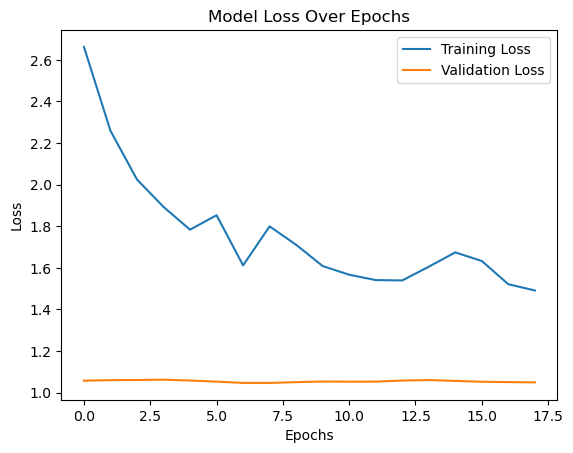

In [171]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [178]:
# Extract scaled train and validation loss from history
scaled_train_loss = history.history['loss'][-1]  # Final train loss
scaled_val_loss = history.history['val_loss'][-1]  # Final validation loss

# Descale train and validation losses using the `scaler`
descaled_train_loss = np.sqrt(scaled_train_loss) * scaler.scale_[0] + scaler.mean_[0]
descaled_val_loss = np.sqrt(scaled_val_loss) * scaler.scale_[0] + scaler.mean_[0]

# Print the descaled losses
print(f"Descaled Training Loss: {descaled_train_loss}")
print(f"Descaled Validation Loss: {descaled_val_loss}")

Descaled Training Loss: 0.013369613676024966
Descaled Validation Loss: 0.012471018114385495


### Evaluation of models tested with different architectures derived from different hyper-parameter tunning approaches. 

### Residuals LSTM Model Performance Comparison for SL = 4

| Metric            | Random Search (Optuna) | Keras Tuner        | Random Search (2 Layers) | Random Search (3 Layers) |
|--------------------|-------------------------|---------------------|---------------------------|---------------------------|
| **Train RMSE**     | 0.01286139             | 0.01286479         | 0.01288824               | 0.01289090               |
| **Test RMSE**      | 0.01576479             | 0.01577477         | 0.01578670               | 0.01574967               |
| **Train MAE**      | 0.00935142             | 0.00935204         | 0.00936385               | 0.00934361               |
| **Test MAE**       | 0.01196766             | 0.01196398         | 0.01198822               | 0.01189268               |
| **Train Loss**     | 1.01299894             | 1.24597538         | 1.17627704               | 1.49120522               |
| **Validation Loss**| 0.87752247             | 1.50954580         | 1.58752072               | 1.04919457               |
| **Train DA**       | 64.41%                 | 68.06%             | 53.18%                   | 50.34%                   |
| **Test DA**        | 67.72%                 | 64.57%             | 55.91%                   | 51.18%                   |
                     
   
- According to the metrics table the Model with Optuna parameter search presents the lowest RMSE and MAE metrics, so as the validation loss. Also, the directional accuracy also in the highest among the models. However, by observing the train and val loss plot, the train loss decrease was not stable. 

### Cross Validation of the best model with SL of 4 with Descaled Metrics. 

- Training and Validation Loss
| **Metric**           | **Loss**       |
|-----------------------|----------------|
| **Training Loss**     | 0.01336961     |
| **Validation Loss**   | 0.01247101     |

- TSCV RMSE Values
| **Fold** | **RMSE**        |
|----------|-----------------|
| Fold 1   | 0.01883255      |
| Fold 2   | 0.01487593      |
| Fold 3   | 0.01078377      |
| Fold 4   | 0.01013835      |

**Average TSCV RMSE**: **0.01365765**

- The type of cross validation where the train data is added throughout folds, the scores shows that the model improves each time the fold is increased. Also, showing values lower than the average in later folds. 

- FRWCV RMSE Values
| **Window** | **RMSE**       |
|------------|----------------|
| Window 1   | 0.01620921     |
| Window 2   | 0.01081760     |
| Window 3   | 0.01151396     |
| Window 4   | 0.00969436     |

**Average FRWCV RMSE**: **0.01214340**

- The scores for the approach presented variability and it ranges from 0.009 to 0.016 and it shows that the model struggles at first window, but performs below average in other windows.

The time-series and fixed rolling window techniques uses different validation set-ups and the present model have averages that are close, suggesting robustness  

In [188]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 64,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.001,
    'l2_lambda': 0.001047148538910998,
    'epochs': 150,
    'dropout_rate': 0.4,
    'clipnorm': 5.0,
    'batch_size': 120
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=False, 
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    optimizer = Adam(learning_rate=params['learning_rate'], 
                     decay=params['learning_rate_decay'], 
                     clipnorm=params['clipnorm'])
    
    # Compile the model
    model.compile(optimizer=optimizer, loss=params['loss_function'])
    
    return model
# Define the number of splits for Time Series Cross-Validation
n_splits = 4
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize the list to store RMSE scores
tscv_rmse_scores = []

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Save the initial model weights to reset after each fold
model = build_best_model(best_params)

# Perform TSCV
for fold, (train_index, test_index) in enumerate(tscv.split(y_train_scaled)):
    print(f"Fold {fold + 1}")
    
    # Define train and test sets
    y_train_fold, y_test_fold = y_train_scaled[train_index], y_train_scaled[test_index]
    
    # Create sequences for TSCV
    X_train_seq, y_train_seq = [], []
    for i in range(len(y_train_fold) - sequence_length):
        X_train_seq.append(y_train_fold[i:i + sequence_length])  # Sequence of past residuals.
        y_train_seq.append(y_train_fold[i + sequence_length])    # Next residual value as target.
    
    X_test_seq, y_test_seq = [], []
    for i in range(len(y_test_fold) - sequence_length):
        X_test_seq.append(y_test_fold[i:i + sequence_length])  # Sequence of past residuals.
        y_test_seq.append(y_test_fold[i + sequence_length])    # Next residual value as target.
    
    # Convert to numpy arrays
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size'],
        validation_data=(X_test_seq, y_test_seq),
        shuffle=False,
        verbose=0,
        callbacks=[early_stopping]
    )
    
    # Predict and evaluate
    y_pred = model.predict(X_test_seq)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    tscv_rmse_scores.append(rmse)
    print(f"Fold {fold + 1} RMSE: {rmse}")

# Calculate the average RMSE across all folds
avg_rmse = np.mean(tscv_rmse_scores)
print(f"Average RMSE from TSCV: {avg_rmse}")

Fold 1
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Fold 1 RMSE: 1.4303160789442968
Fold 2
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Fold 2 RMSE: 1.1233446879246012
Fold 3
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Fold 3 RMSE: 0.8058579852076291
Fold 4
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Fold 4 RMSE: 0.7557832870102502
Average RMSE from TSCV: 1.0288255097716943


In [192]:
# Parameters for FRWCV
train_window = 300  # Training window size
test_window = 100    # Test window size

# Store RMSEs for each window
rolling_rmse_scores = []

for start in range(0, len(y_train_scaled) - train_window - test_window, test_window):
    print(f"Rolling window starting at index {start}")
    
    # Define train and test sets for the window
    y_train_fold = y_train_scaled[start:start + train_window]
    y_test_fold = y_train_scaled[start + train_window:start + train_window + test_window]
    
    # Create sequences for FRWCV
    X_train_seq, y_train_seq = [], []
    for i in range(len(y_train_fold) - sequence_length):
        X_train_seq.append(y_train_fold[i:i + sequence_length])  # Sequence of past residuals.
        y_train_seq.append(y_train_fold[i + sequence_length])    # Next residual value as target.
    
    X_test_seq, y_test_seq = [], []
    for i in range(len(y_test_fold) - sequence_length):
        X_test_seq.append(y_test_fold[i:i + sequence_length])  # Sequence of past residuals.
        y_test_seq.append(y_test_fold[i + sequence_length])    # Next residual value as target.
    
    # Convert to numpy arrays
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=best_params['epochs'], 
        batch_size=best_params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        shuffle=False,
        verbose=0,  # Suppress training logs for brevity
        callbacks=[early_stopping]
    )
    
    # Evaluate on the test set
    y_pred = model.predict(X_test_seq)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    rolling_rmse_scores.append(rmse)
    print(f"Rolling window RMSE: {rmse}")

# Calculate average RMSE across rolling windows
avg_rolling_rmse = np.mean(rolling_rmse_scores)
print(f"Average Rolling Window RMSE: {avg_rolling_rmse}")

Rolling window starting at index 0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Rolling window RMSE: 1.2267865770901223
Rolling window starting at index 100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
Rolling window RMSE: 0.8084829240020616
Rolling window starting at index 200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
Rolling window RMSE: 0.8625088484775079
Rolling window starting at index 300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Rolling window RMSE: 0.72133669809557
Average Rolling Window RMSE: 0.9047787619163155


In [193]:
# Function to descale RMSE
def descale_rmse(scaled_rmse, scaler):
    # Reshape RMSE value to fit scaler requirements
    scaled_rmse_array = np.array(scaled_rmse).reshape(-1, 1)
    # Inverse transform the RMSE
    descaled_rmse_array = scaler.inverse_transform(scaled_rmse_array)
    # Return the descaled RMSE as a list
    return descaled_rmse_array.flatten().tolist()

# Descale TSCV RMSE values
descaled_tscv_rmse = descale_rmse(tscv_rmse_scores, scaler)
print("Descaled TSCV RMSE Values:", descaled_tscv_rmse)

# Descale FRWCV RMSE values
descaled_frwcv_rmse = descale_rmse(rolling_rmse_scores, scaler)
print("Descaled FRWCV RMSE Values:", descaled_frwcv_rmse)

# Calculates average descaled RMSE
average_tscv_rmse = np.mean(descaled_tscv_rmse)
average_frwcv_rmse = np.mean(descaled_frwcv_rmse)
print(f"Average Descaled TSCV RMSE: {average_tscv_rmse}")
print(f"Average Descaled FRWCV RMSE: {average_frwcv_rmse}")

Descaled TSCV RMSE Values: [0.01883255272104779, 0.014875928727971742, 0.01078377049368216, 0.010138346333223249]
Descaled FRWCV RMSE Values: [0.016209214736162502, 0.010817603926106947, 0.011513956339657922, 0.009694356423522815]
Average Descaled TSCV RMSE: 0.013657649568981235
Average Descaled FRWCV RMSE: 0.012058782856362547


## Sequence Length = 12

In [128]:
# Reshape residual data into sequences for LSTM.
sequence_length = 12  # Number of time steps used for target prediction.

# Initialize empty lists for the training set.
X_train_seq, y_train_seq = [], []
# Loop through the scaled training residuals to create sequences and targets.
for i in range(len(y_train_scaled) - sequence_length):
    X_train_seq.append(y_train_scaled[i:i + sequence_length])  # Sequence of past residuals.
    y_train_seq.append(y_train_scaled[i + sequence_length])    # Next residual value as target.

# Initialize empty lists for the test set.
X_test_seq, y_test_seq = [], []
# Loop through the scaled test residuals to create sequences and targets.
for i in range(len(y_test_scaled) - sequence_length):
    X_test_seq.append(y_test_scaled[i:i + sequence_length])  # Sequence of past residuals.
    y_test_seq.append(y_test_scaled[i + sequence_length])    # Next residual value as target.

# Convert lists to numpy arrays to use in LSTM model.
X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)

# Print the reshaped input and target data shapes for verification.
print(f"Reshaped X_train_seq shape: {X_train_seq.shape}")  
print(f"Reshaped y_train_seq shape: {y_train_seq.shape}")  
print(f"Reshaped X_test_seq shape: {X_test_seq.shape}")    
print(f"Reshaped y_test_seq shape: {y_test_seq.shape}")    

Reshaped X_train_seq shape: (732, 12, 1)
Reshaped y_train_seq shape: (732, 1)
Reshaped X_test_seq shape: (120, 12, 1)
Reshaped y_test_seq shape: (120, 1)


### Random Search with Optuna

In [98]:
# Set global random state for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Optuna's TPESampler with a fixed random seed for reproducibility in parameter search.
sampler = TPESampler(seed=random_seed)

# Create an Optuna study with direction "minimize" to minimize the validation loss.
study = optuna.create_study(direction="minimize", sampler=sampler)

# Define the objective function for hyperparameter optimization.
def lstm_objective(trial):
    """
    Objective function for Optuna to optimize hyperparameters of a LSTM model.
    This version uses residuals only, without additional features.
    """

    # Define hyperparameters to tune.
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.4, step=0.1)  # Dropout rate for LSTM layers.
    recurrent_dropout = trial.suggest_categorical("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout rate.
    l2_lambda = trial.suggest_loguniform("l2_lambda", 1e-3, 1e-1)  # L2 regularization factor.
    learning_rate = trial.suggest_categorical("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate for the optimizer.
    learning_rate_decay = trial.suggest_categorical("learning_rate_decay", [1e-6, 1e-5, 0])  # Learning rate decay.
    clipnorm = trial.suggest_categorical("clipnorm", [1.0, 5.0])  # Gradient clipping norm.
    units = trial.suggest_categorical("units", [32, 64, 128])  # Number of units in LSTM layers.
    num_layers = trial.suggest_int("num_layers", 1, 3)  # Number of LSTM layers.
    epochs = trial.suggest_int("epochs", 50, 200, step=50)  # Number of epochs.
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 120, 256])  # Batch size.

    # Initialize the Sequential model.
    model = Sequential()

    # Add LSTM layers based on num_layers.
    for i in range(num_layers):
        # Set return_sequences=True for all but the last LSTM layer.
        return_sequences = (i < num_layers - 1)
        
        # Add LSTM layer with specified hyperparameters.
        model.add(LSTM(
            units=units,
            return_sequences=return_sequences,
            input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,  # Input shape only for the first layer.
            kernel_regularizer=l2(l2_lambda),
            recurrent_dropout=recurrent_dropout
        ))

        # Add BatchNormalization and Dropout after each LSTM layer.
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    # Add the output layer with a single unit (regression).
    model.add(Dense(1))

    # Initialize the optimizer with learning rate, decay, and gradient clipping norm.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)

    # Compile the model with mean squared error loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Early stopping callback to avoid overfitting.
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model with given hyperparameters.
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test_seq, y_test_seq),
        shuffle=False,
        callbacks=[early_stopping],
        verbose=0  # Set verbose=0 to suppress training logs for faster experimentation.
    )

    # Retrieve the minimum validation loss from the training history.
    val_loss = min(history.history['val_loss'])
    
    # Return the validation loss to be minimized by Optuna.
    return val_loss

# Run the Optuna study for a given number of trials.
study.optimize(lstm_objective, n_trials=30)

# Print the best parameters found by the study.
print("Best hyperparameters:", study.best_params)

# Print the best validation loss achieved with the optimal parameters.
print("Best validation loss:", study.best_value)

[I 2024-11-26 14:58:09,484] A new study created in memory with name: no-name-33f0917a-d8ed-4102-b90d-2d3cc5f31622
[I 2024-11-26 14:58:16,226] Trial 0 finished with value: 2.0171756744384766 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.0037550037026405905, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 3, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 2.0171756744384766.
[I 2024-11-26 14:58:22,915] Trial 1 finished with value: 3.798988103866577 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.04641587067816149, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 2, 'epochs': 50, 'batch_size': 256}. Best is trial 0 with value: 2.0171756744384766.
[I 2024-11-26 14:58:41,288] Trial 2 finished with value: 4.351269721984863 and parameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0.2

Best hyperparameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0.1, 'l2_lambda': 0.028980866560207673, 'learning_rate': 0.0005, 'learning_rate_decay': 1e-06, 'clipnorm': 1.0, 'units': 64, 'num_layers': 1, 'epochs': 200, 'batch_size': 120}
Best validation loss: 1.5513828992843628


In [29]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 64,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-06,
    'learning_rate': 0.0005,
    'l2_lambda': 0.028980866560207673,
    'epochs': 200,
    'dropout_rate': 0.4,
    'clipnorm': 1.0,
    'batch_size': 120
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))

    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 1.3737 - val_loss: 1.6380
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3623 - val_loss: 1.6340
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4389 - val_loss: 1.6314
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3226 - val_loss: 1.6304
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3127 - val_loss: 1.6289
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3037 - val_loss: 1.6265
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2403 - val_loss: 1.6234
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2926 - val_loss: 1.6226
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3005 - val_loss: 1.6197
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2703 - val_loss: 1.6164
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1934 - val_loss: 1.6151
Epoch 12/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2308 - val_loss: 1.6162


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
LSTM Model Performance:
Training RMSE: 0.013073139564406963
Test RMSE: 0.01609458235426328
Training MAE: 0.009331398297578819
Test MAE: 0.011711881981508984
Directional Accuracy on Training Data: 68.12585499316005%
Directional Accuracy on Test Data: 74.78991596638656%


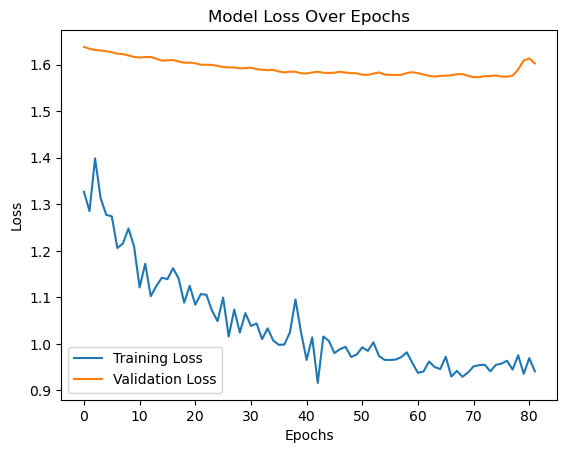

In [31]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Keras Tuner

In [99]:
# Set a global random seed for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Build LSTM model function with hyperparameter choices.
def build_lstm_model_tuner(hp):
    """
    Build an LSTM model for KerasTuner to optimize. Uses only residual sequences for input.
    """

    model = Sequential()

    # Define hyperparameters using `hp` for tuning options.
    dropout_rate = hp.Choice("dropout_rate", [0.2, 0.3, 0.4])  # Dropout rates.
    recurrent_dropout = hp.Choice("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout.
    l2_lambda = hp.Float("l2_lambda", min_value=0.001, max_value=0.1, sampling="log")  # L2 regularization.
    learning_rate = hp.Choice("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate.
    learning_rate_decay = hp.Choice("learning_rate_decay", [1e-5, 0.0])  # Learning rate decay.
    clipnorm = hp.Choice("clipnorm", [1.0, 5.0])  # Gradient clipping norm.
    units = hp.Choice("units", [32, 64, 128])  # Number of units in LSTM layers.
    num_layers = hp.Int("num_layers", 1, 3)  # Number of LSTM layers.
    batch_size = hp.Choice("batch_size", [32, 64, 120, 256])  # Batch size.

    # Add LSTM layers based on the number of layers selected.
    for i in range(num_layers):
        return_sequences = (i < num_layers - 1)  # Return sequences for intermediate layers only.
        model.add(LSTM(
            units=units,
            return_sequences=return_sequences,
            input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,
            kernel_regularizer=l2(l2_lambda),
            recurrent_dropout=recurrent_dropout
        ))
        model.add(BatchNormalization())  # Batch normalization to stabilize training.
        model.add(Dropout(dropout_rate))  # Dropout to combat overfitting.

    # Add the output layer (regression).
    model.add(Dense(1))

    # Configure optimizer with learning rate, decay, and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)

    # Compile the model.
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Print hyperparameters for debugging.
    print(f"Built model with params: dropout_rate={dropout_rate}, recurrent_dropout={recurrent_dropout}, "
          f"l2_lambda={l2_lambda}, learning_rate={learning_rate}, learning_rate_decay={learning_rate_decay}, "
          f"clipnorm={clipnorm}, units={units}, num_layers={num_layers}, batch_size={batch_size}")

    return model


# Set up Bayesian Optimization tuner to search for optimal hyperparameters.
tuner = BayesianOptimization(
    build_lstm_model_tuner,  # Model-building function.
    objective="val_loss",  # Target metric for optimization.
    max_trials=30,  # Maximum number of trials to run.
    executions_per_trial=1,  # Number of executions per trial.
    directory="sarimax-lstm",  # Directory to store tuning results.
    project_name="sarimax-lstm",  # Project name for the tuner.
    overwrite=True  # Overwrite previous tuner results if they exist.
)

# Define early stopping to prevent overfitting.
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Perform the hyperparameter search using the residuals (no features).
tuner.search(
    X_train_seq, y_train_seq,  # Training sequences and targets.
    validation_data=(X_test_seq, y_test_seq),  # Validation sequences and targets.
    epochs=200,  # Max number of epochs for each trial.
    callbacks=[early_stopping],  # Early stopping to avoid overfitting.
    shuffle=False,  # Ensure the time series order is preserved.
    verbose=1  # Show progress for each trial.
)

# Retrieve the best model and hyperparameters from the tuner.
best_lstm_model = tuner.get_best_models(num_models=1)[0]
best_lstm_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters found by KerasTuner.
print("Best hyperparameters for LSTM:", best_lstm_hyperparameters.values)
print("Best batch size for LSTM:", best_lstm_hyperparameters.get("batch_size"))

Trial 30 Complete [00h 00m 05s]
val_loss: 1.569340705871582

Best val_loss So Far: 1.5450432300567627
Total elapsed time: 00h 06m 50s
Built model with params: dropout_rate=0.2, recurrent_dropout=0.2, l2_lambda=0.005777535037556758, learning_rate=0.001, learning_rate_decay=1e-05, clipnorm=1.0, units=128, num_layers=1, batch_size=256
Best hyperparameters for LSTM: {'dropout_rate': 0.2, 'recurrent_dropout': 0.2, 'l2_lambda': 0.005777535037556758, 'learning_rate': 0.001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 128, 'num_layers': 1, 'batch_size': 256}
Best batch size for LSTM: 256


In [33]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.001,
    'l2_lambda': 0.005777535037556758,
    'epochs': 200,
    'dropout_rate': 0.2,
    'clipnorm': 1.0,
    'batch_size': 256
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))

    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss: 1.3497 - val_loss: 1.5904
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.2727 - val_loss: 1.5920
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.2298 - val_loss: 1.5856
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 1.2868 - val_loss: 1.5866
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1.3167 - val_loss: 1.5881
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.2185 - val_loss: 1.5844
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.2594 - val_loss: 1.5848
Epoch 8/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.1939 - val_loss: 1.5851
Epoch 9/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.1514 - val_loss: 1.5848
Epoch 10/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.1220 - val_loss: 1.5845
Epoch 11/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.1499 - val_loss: 1.5837
Epoch 12/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.2311 - val_l

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
LSTM Model Performance:
Training RMSE: 0.012910918666452904
Test RMSE: 0.016140130477788055
Training MAE: 0.009339952890977322
Test MAE: 0.012168145665174634
Directional Accuracy on Training Data: 68.80984952120383%
Directional Accuracy on Test Data: 72.26890756302521%


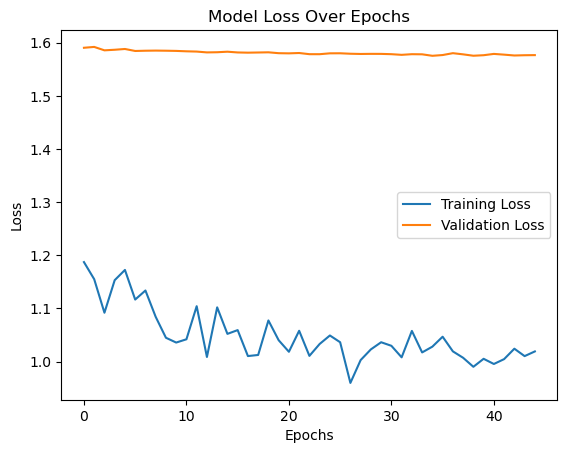

In [35]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Random Search with 2 Layers

In [103]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid for random hyperparameter search.
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],               # Dropout rate for regularization.
    'recurrent_dropout': [0.1, 0.2],               # Recurrent dropout within LSTM layers.
    'l2_lambda': [0.001, 0.01, 0.1],               # L2 regularization strength.
    'learning_rate': [0.001, 0.0005, 0.0001],      # Learning rate for optimizer.
    'learning_rate_decay': [1e-6, 1e-5, 0],        # Decay rate for learning rate over time.
    'units1': [32, 64, 128],                       # Number of units in the first LSTM layer.
    'units2': [32, 64, 128],                       # Number of units in the second LSTM layer.
    'batch_size': [32, 64, 120, 256],              # Batch size for training.
    'epochs': [50, 100, 200],                      # Number of epochs to train.
    'optimizer': ['adam'],                         # Optimizer to use.
    'clipnorm': [1.0, 5.0]                         # Gradient clipping to avoid exploding gradients.
}

# Generate a list of random combinations of hyperparameters.
n_iter_search = 30  # Number of random combinations to attempt.
# Random state being applied for reproducibility. 
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42)) 

# Define a function to build the LSTM model with given parameters.
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, optimizer_name, loss_function):
    model = Sequential()
    
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape based on sequence data.
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())  # Batch normalization for stable training.
    model.add(Dropout(dropout_rate))  # Dropout for regularization.
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units2, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer with a single unit for regression output.
    model.add(Dense(1))
    
    # Select optimizer with learning rate decay and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile the model with the chosen optimizer and loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Define early stopping to stop training when validation loss does not improve.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to store results of each model configuration.
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.01, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 5.0, 'batch_size': 64}
Final Training Loss: 1.4130665063858032
Final Validation Loss: 1.9176242351531982
Running combination 2/30: {'units2': 128, 'units1': 64, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.001, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 1.7051793336868286
Final Validation Loss: 2.059649705886841
Running combination 3/30: {'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 1.0, 'batch_size': 64}
Final Training Loss: 1.2450042963027954
Final Validation Loss: 1.7730085849761963
Running combination 4

In [37]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 64,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.001,
    'l2_lambda': 0.001,
    'epochs': 200,
    'dropout_rate': 0.3,
    'clipnorm': 1.0,
    'batch_size': 256
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=False, 
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - loss: 4.5750 - val_loss: 1.6430
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.7126 - val_loss: 1.6416
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.6240 - val_loss: 1.6394
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.2971 - val_loss: 1.6397
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.3013 - val_loss: 1.6384
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.1279 - val_loss: 1.6363
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 2.0218 - val_loss: 1.6371
Epoch 8/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.1766 - val_loss: 1.6401
Epoch 9/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.8977 - val_loss: 1.6412
Epoch 10/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.8559 - val_loss: 1.6406
Epoch 11/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.8268 - val_loss: 1.6413
Epoch 12/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 2.0398 - val_l

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
LSTM Model Performance:
Training RMSE: 0.01292172104241744
Test RMSE: 0.0161910935958883
Training MAE: 0.009385289418918067
Test MAE: 0.012356616866696953
Directional Accuracy on Training Data: 55.54035567715459%
Directional Accuracy on Test Data: 55.46218487394958%


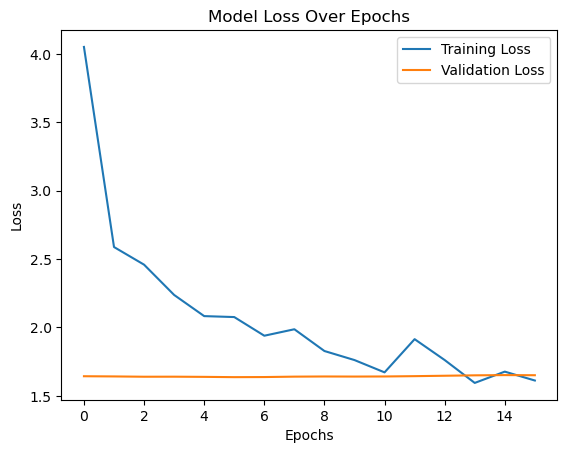

In [39]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Random Search with 3 Layers

In [101]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],
    'recurrent_dropout': [0.1, 0.2],
    'l2_lambda': [0.001, 0.01, 0.1],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'learning_rate_decay': [1e-6, 1e-5, 0],
    'units1': [32, 64, 128],
    'units2': [32, 64, 128],
    'units3': [32, 64, 128],
    'batch_size': [32, 64, 120, 256],  
    'epochs': [50, 100, 200],
    'optimizer': ['adam'],
    'clipnorm': [1.0, 5.0]
}

# Generate a list of random combinations with ParameterSampler
n_iter_search = 30
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42))

# Define the function to build the model with variable parameters
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, units3, optimizer_name, loss_function):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units2, return_sequences=True, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units3, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer.
    model.add(Dense(1))
    
    # Select optimizer with decay and clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to keep track of results
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        units3=params['units3'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        shuffle=False,
        callbacks=[early_stopping],
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units3': 32, 'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 5.0, 'batch_size': 32}
Final Training Loss: 1.0222790241241455
Final Validation Loss: 1.966407299041748
Running combination 2/30: {'units3': 128, 'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0001, 'l2_lambda': 0.01, 'epochs': 50, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 4.0466814041137695
Final Validation Loss: 4.254885196685791
Running combination 3/30: {'units3': 128, 'units2': 64, 'units1': 64, 'recurrent_dropout': 0.1, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.4, 'clipnorm': 5.0, 'batch_size': 256}
Final Training Loss: 2.695014238357544
Final Validat

In [130]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 32,
    'units3': 64,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.0001,
    'l2_lambda': 0.001,
    'epochs': 100,
    'dropout_rate': 0.3,
    'clipnorm': 1.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))

        # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units3'], return_sequences=False, 
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 3.5466 - val_loss: 1.7036
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.7189 - val_loss: 1.7049
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.4144 - val_loss: 1.7062
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.1505 - val_loss: 1.7059
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.3494 - val_loss: 1.7066
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.8646 - val_loss: 1.7058
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.1688 - val_loss: 1.7029
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.9813 - val_loss: 1.7054
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.9715 - val_loss: 1.7032
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.2028 - val_loss: 1.6887
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.0693 - val_loss: 1.6824
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
LSTM Model Performance:
Training RMSE: 0.013173204397060687
Test RMSE: 0.015905456345998457
Training MAE: 0.009608396166089474
Test MAE: 0.012188642985559136
Directional Accuracy on Training Data: 57.045143638850895%
Directional Accuracy on Test Data: 59.66386554621849%


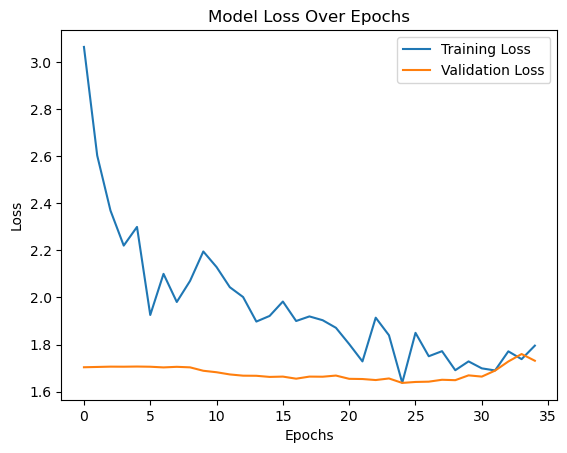

In [152]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [131]:
# Extract scaled train and validation loss from history
scaled_train_loss = history.history['loss'][-1]  # Final train loss
scaled_val_loss = history.history['val_loss'][-1]  # Final validation loss

# Descale train and validation losses using the `scaler`
descaled_train_loss = np.sqrt(scaled_train_loss) * scaler.scale_[0] + scaler.mean_[0]
descaled_val_loss = np.sqrt(scaled_val_loss) * scaler.scale_[0] + scaler.mean_[0]

# Print the descaled losses
print(f"Descaled Training Loss: {descaled_train_loss}")
print(f"Descaled Validation Loss: {descaled_val_loss}")

Descaled Training Loss: 0.01766732936501063
Descaled Validation Loss: 0.017355902653075062



### Model Performance Comparison (Sequence Length = 12)

| **Metric**            | **Random Search (Optuna)** | **Keras Tuner** | **Random Search (2 Layers)** | **Random Search (3 Layers)** |
|------------------------|---------------------------|-----------------|-----------------------------|-----------------------------|
| **Train RMSE**         | 0.01307314               | 0.01291092      | 0.01292172                  | 0.01317320                  |
| **Test RMSE**          | 0.01609458               | 0.01614013      | 0.01619109                  | 0.01590546                  |
| **Train MAE**          | 0.00933140               | 0.00933995      | 0.00938529                  | 0.00960840                  |
| **Test MAE**           | 0.01171188               | 0.01216815      | 0.01235662                  | 0.01218864                  |
| **Train Loss**         | 0.94110531               | 1.01925111      | 1.61168766                  | 1.79536736                  |
| **Validation Loss**    | 1.60254228               | 1.57655883      | 1.65042019                  | 1.73120177                  |
| **Train DA**           | 68.13%                   | 68.81%          | 55.54%                      | 57.05%                      |
| **Test DA**            | 74.79%                   | 72.27%          | 55.46%                      | 59.66%                      |


- With sequence length of 12, the models performs quite similar to each other, the random search (3 layers) yielded a slightly better RMSE and Optuna and Keras tuner parameters are better able to capture trends in residuals (higher DA). However, by observing the train and val loss, the models starts to overfit (val loss start to increase). Thus, or a different sequence length of different architectuure to avoid overfitting issue.

### Cross Validation of best model with descaled metrics (SL = 12).

#### Training and Validation Loss.
| **Metric**           | **Loss**       |
|-----------------------|----------------|
| **Training Loss**     | 0.01766732     |
| **Validation Loss**   | 0.01735590     |

#### TSCV RMSE Values.
| **Fold** | **RMSE**        |
|----------|-----------------|
| Fold 1   | 0.01920988      |
| Fold 2   | 0.01511425      |
| Fold 3   | 0.01102393      |
| Fold 4   | 0.00999259      |

- Like the previous SL, the models performs better in later folds, it might have learnt patterns from previous folds. 

**Average TSCV RMSE**: **0.01383516**

#### FRWCV RMSE Values.
| **Window** | **RMSE**       |
|------------|----------------|
| Window 1   | 0.01661797     |
| Window 2   | 0.01107657     |
| Window 3   | 0.01200523     |
| Window 4   | 0.00986717     |

**Average FRWCV RMSE**: **0.01239173**

- The model performs above average only in the first window, indicating that the models adapts well to new windows.

In [42]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 32,
    'units3': 64,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.0001,
    'l2_lambda': 0.001,
    'epochs': 100,
    'dropout_rate': 0.3,
    'clipnorm': 1.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))

        # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units3'], return_sequences=False, 
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    optimizer = Adam(learning_rate=params['learning_rate'], 
                     decay=params['learning_rate_decay'], 
                     clipnorm=params['clipnorm'])
    
    # Compile the model
    model.compile(optimizer=optimizer, loss=params['loss_function'])
    
    return model
# Define the number of splits for Time Series Cross-Validation
n_splits = 4
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize the list to store RMSE scores
tscv_rmse_scores = []

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Save the initial model weights to reset after each fold
model = build_best_model(best_params)
initial_weights = model.get_weights()

# Perform TSCV
for fold, (train_index, test_index) in enumerate(tscv.split(y_train_scaled)):
    print(f"Fold {fold + 1}")

    # Reset model to initial weights
    model.set_weights(initial_weights)
    
    # Define train and test sets
    y_train_fold, y_test_fold = y_train_scaled[train_index], y_train_scaled[test_index]
    
    # Create sequences for TSCV
    X_train_seq, y_train_seq = [], []
    for i in range(len(y_train_fold) - sequence_length):
        X_train_seq.append(y_train_fold[i:i + sequence_length])  # Sequence of past residuals.
        y_train_seq.append(y_train_fold[i + sequence_length])    # Next residual value as target.
    
    X_test_seq, y_test_seq = [], []
    for i in range(len(y_test_fold) - sequence_length):
        X_test_seq.append(y_test_fold[i:i + sequence_length])  # Sequence of past residuals.
        y_test_seq.append(y_test_fold[i + sequence_length])    # Next residual value as target.
    
    # Convert to numpy arrays
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size'],
        validation_data=(X_test_seq, y_test_seq),
        shuffle=False,
        verbose=0,
        callbacks=[early_stopping]
    )
    
    # Predict and evaluate
    y_pred = model.predict(X_test_seq)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    tscv_rmse_scores.append(rmse)
    print(f"Fold {fold + 1} RMSE: {rmse}")

# Calculate the average RMSE across all folds
avg_rmse = np.mean(tscv_rmse_scores)
print(f"Average RMSE from TSCV: {avg_rmse}")

Fold 1
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
Fold 1 RMSE: 1.459590953204199
Fold 2
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 2 RMSE: 1.1418346240631305
Fold 3
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Fold 3 RMSE: 0.8244907324443576
Fold 4
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Fold 4 RMSE: 0.744474894919646
Average RMSE from TSCV: 1.0425978011578334


In [43]:
# Parameters for FRWCV
train_window = 300  # Training window size
test_window = 100    # Test window size

# Store RMSEs for each window
rolling_rmse_scores = []

for start in range(0, len(y_train_scaled) - train_window - test_window, test_window):
    print(f"Rolling window starting at index {start}")
    
    # Define train and test sets for the window
    y_train_fold = y_train_scaled[start:start + train_window]
    y_test_fold = y_train_scaled[start + train_window:start + train_window + test_window]
    
    # Create sequences for FRWCV
    X_train_seq, y_train_seq = [], []
    for i in range(len(y_train_fold) - sequence_length):
        X_train_seq.append(y_train_fold[i:i + sequence_length])  # Sequence of past residuals.
        y_train_seq.append(y_train_fold[i + sequence_length])    # Next residual value as target.
    
    X_test_seq, y_test_seq = [], []
    for i in range(len(y_test_fold) - sequence_length):
        X_test_seq.append(y_test_fold[i:i + sequence_length])  # Sequence of past residuals.
        y_test_seq.append(y_test_fold[i + sequence_length])    # Next residual value as target.
    
    # Convert to numpy arrays
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)
    
    # Train the model
    model.set_weights(initial_weights)  # Reset to initial weights
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=best_params['epochs'], 
        batch_size=best_params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        shuffle=False,
        verbose=0,  # Suppress training logs for brevity
        callbacks=[early_stopping]
    )
    
    # Evaluate on the test set
    y_pred = model.predict(X_test_seq)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    rolling_rmse_scores.append(rmse)
    print(f"Rolling window RMSE: {rmse}")

# Calculate average RMSE across rolling windows
avg_rolling_rmse = np.mean(rolling_rmse_scores)
print(f"Average Rolling Window RMSE: {avg_rolling_rmse}")

Rolling window starting at index 0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Rolling window RMSE: 1.2584996862163451
Rolling window starting at index 100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Rolling window RMSE: 0.8285747117254278
Rolling window starting at index 200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Rolling window RMSE: 0.9006238147876362
Rolling window starting at index 300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Rolling window RMSE: 0.7347439663491202
Average Rolling Window RMSE: 0.9306105447696323


In [45]:
# Function to descale RMSE
def descale_rmse(scaled_rmse, scaler):
    # Reshape RMSE value to fit scaler requirements
    scaled_rmse_array = np.array(scaled_rmse).reshape(-1, 1)
    # Inverse transform the RMSE
    descaled_rmse_array = scaler.inverse_transform(scaled_rmse_array)
    # Return the descaled RMSE as a list
    return descaled_rmse_array.flatten().tolist()

# Descale TSCV RMSE values
descaled_tscv_rmse = descale_rmse(tscv_rmse_scores, scaler)
print("Descaled TSCV RMSE Values:", descaled_tscv_rmse)

# Descale FRWCV RMSE values
descaled_frwcv_rmse = descale_rmse(rolling_rmse_scores, scaler)
print("Descaled FRWCV RMSE Values:", descaled_frwcv_rmse)

# Calculates average descaled RMSE
average_tscv_rmse = np.mean(descaled_tscv_rmse)
average_frwcv_rmse = np.mean(descaled_frwcv_rmse)
print(f"Average Descaled TSCV RMSE: {average_tscv_rmse}")
print(f"Average Descaled FRWCV RMSE: {average_frwcv_rmse}")

Descaled TSCV RMSE Values: [0.019209883225712255, 0.015114249715191867, 0.011023932205589154, 0.009992589898657249]
Descaled FRWCV RMSE Values: [0.01661797220390907, 0.011076571542294219, 0.01200522879894799, 0.009867165749751525]
Average Descaled TSCV RMSE: 0.013835163761287633
Average Descaled FRWCV RMSE: 0.0123917345737257


## Sequence Length = 26

In [107]:
# Reshape residual data into sequences for LSTM.
sequence_length = 26  # Number of time steps used for target prediction.

# Initialize empty lists for the training set.
X_train_seq, y_train_seq = [], []
# Loop through the scaled training residuals to create sequences and targets.
for i in range(len(y_train_scaled) - sequence_length):
    X_train_seq.append(y_train_scaled[i:i + sequence_length])  # Sequence of past residuals.
    y_train_seq.append(y_train_scaled[i + sequence_length])    # Next residual value as target.

# Initialize empty lists for the test set.
X_test_seq, y_test_seq = [], []
# Loop through the scaled test residuals to create sequences and targets.
for i in range(len(y_test_scaled) - sequence_length):
    X_test_seq.append(y_test_scaled[i:i + sequence_length])  # Sequence of past residuals.
    y_test_seq.append(y_test_scaled[i + sequence_length])    # Next residual value as target.

# Convert lists to numpy arrays to use in LSTM model.
X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)

# Print the reshaped input and target data shapes for verification.
print(f"Reshaped X_train_seq shape: {X_train_seq.shape}") 
print(f"Reshaped y_train_seq shape: {y_train_seq.shape}") 
print(f"Reshaped X_test_seq shape: {X_test_seq.shape}")    
print(f"Reshaped y_test_seq shape: {y_test_seq.shape}")    

Reshaped X_train_seq shape: (718, 26, 1)
Reshaped y_train_seq shape: (718, 1)
Reshaped X_test_seq shape: (106, 26, 1)
Reshaped y_test_seq shape: (106, 1)


### Random Search with Optuna

In [105]:
# Set global random state for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Optuna's TPESampler with a fixed random seed for reproducibility in parameter search.
sampler = TPESampler(seed=random_seed)

# Create an Optuna study with direction "minimize" to minimize the validation loss.
study = optuna.create_study(direction="minimize", sampler=sampler)

# Define the objective function for hyperparameter optimization.
def lstm_objective(trial):
    """
    Objective function for Optuna to optimize hyperparameters of a LSTM model.
    This version uses residuals only, without additional features.
    """

    # Define hyperparameters to tune.
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.4, step=0.1)  # Dropout rate for LSTM layers.
    recurrent_dropout = trial.suggest_categorical("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout rate.
    l2_lambda = trial.suggest_loguniform("l2_lambda", 1e-3, 1e-1)  # L2 regularization factor.
    learning_rate = trial.suggest_categorical("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate for the optimizer.
    learning_rate_decay = trial.suggest_categorical("learning_rate_decay", [1e-6, 1e-5, 0])  # Learning rate decay.
    clipnorm = trial.suggest_categorical("clipnorm", [1.0, 5.0])  # Gradient clipping norm.
    units = trial.suggest_categorical("units", [32, 64, 128])  # Number of units in LSTM layers.
    num_layers = trial.suggest_int("num_layers", 1, 3)  # Number of LSTM layers.
    epochs = trial.suggest_int("epochs", 50, 200, step=50)  # Number of epochs.
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 120, 256])  # Batch size.

    # Initialize the Sequential model.
    model = Sequential()

    # Add LSTM layers based on num_layers.
    for i in range(num_layers):
        # Set return_sequences=True for all but the last LSTM layer.
        return_sequences = (i < num_layers - 1)
        
        # Add LSTM layer with specified hyperparameters.
        model.add(LSTM(
            units=units,
            return_sequences=return_sequences,
            input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,  # Input shape only for the first layer.
            kernel_regularizer=l2(l2_lambda),
            recurrent_dropout=recurrent_dropout
        ))

        # Add BatchNormalization and Dropout after each LSTM layer.
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    # Add the output layer with a single unit (regression).
    model.add(Dense(1))

    # Initialize the optimizer with learning rate, decay, and gradient clipping norm.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)

    # Compile the model with mean squared error loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Early stopping callback to avoid overfitting.
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model with given hyperparameters.
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test_seq, y_test_seq),
        shuffle=False,
        callbacks=[early_stopping],
        verbose=0  # Set verbose=0 to suppress training logs for faster experimentation.
    )

    # Retrieve the minimum validation loss from the training history.
    val_loss = min(history.history['val_loss'])
    
    # Return the validation loss to be minimized by Optuna.
    return val_loss

# Run the Optuna study for a given number of trials.
study.optimize(lstm_objective, n_trials=30)

# Print the best parameters found by the study.
print("Best hyperparameters:", study.best_params)

# Print the best validation loss achieved with the optimal parameters.
print("Best validation loss:", study.best_value)

[I 2024-11-26 15:17:22,259] A new study created in memory with name: no-name-5be1fa98-000c-4325-a821-03469c4cec90
[I 2024-11-26 15:17:29,357] Trial 0 finished with value: 1.8788337707519531 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.0037550037026405905, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 3, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 1.8788337707519531.
[I 2024-11-26 15:17:37,481] Trial 1 finished with value: 3.559797763824463 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.04641587067816149, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 2, 'epochs': 50, 'batch_size': 256}. Best is trial 0 with value: 1.8788337707519531.
[I 2024-11-26 15:18:08,771] Trial 2 finished with value: 4.231538772583008 and parameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0.2

Best hyperparameters: {'dropout_rate': 0.2, 'recurrent_dropout': 0.2, 'l2_lambda': 0.002484158683943087, 'learning_rate': 0.001, 'learning_rate_decay': 0, 'clipnorm': 5.0, 'units': 64, 'num_layers': 1, 'epochs': 100, 'batch_size': 32}
Best validation loss: 1.1650946140289307


In [77]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 64,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.001,
    'l2_lambda': 0.002484158683943087,
    'epochs': 100,
    'dropout_rate': 0.2,
    'clipnorm': 5.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 1.0581 - val_loss: 1.2691
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0702 - val_loss: 1.2789
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0692 - val_loss: 1.2697
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0676 - val_loss: 1.2696
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9990 - val_loss: 1.2664
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0020 - val_loss: 1.2709
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0316 - val_loss: 1.2580
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0009 - val_loss: 1.2553
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0586 - val_loss: 1.2551
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9916 - val_loss: 1.2482
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0209 - val_loss: 1.2469
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
LSTM Model Performance:
Training RMSE: 0.012937459733453944
Test RMSE: 0.015096110608262178
Training MAE: 0.009406792294669657
Test MAE: 0.011322478625364887
Directional Accuracy on Training Data: 72.10599721059972%
Directional Accuracy on Test Data: 72.38095238095238%


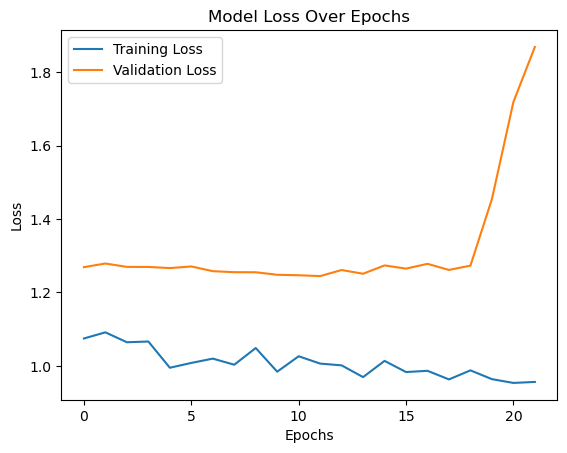

In [78]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Keras Tuner

In [106]:
# Set a global random seed for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Build LSTM model function with hyperparameter choices.
def build_lstm_model_tuner(hp):
    """
    Build an LSTM model for KerasTuner to optimize. Uses only residual sequences for input.
    """

    model = Sequential()

    # Define hyperparameters using `hp` for tuning options.
    dropout_rate = hp.Choice("dropout_rate", [0.2, 0.3, 0.4])  # Dropout rates.
    recurrent_dropout = hp.Choice("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout.
    l2_lambda = hp.Float("l2_lambda", min_value=0.001, max_value=0.1, sampling="log")  # L2 regularization.
    learning_rate = hp.Choice("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate.
    learning_rate_decay = hp.Choice("learning_rate_decay", [1e-5, 0.0])  # Learning rate decay.
    clipnorm = hp.Choice("clipnorm", [1.0, 5.0])  # Gradient clipping norm.
    units = hp.Choice("units", [32, 64, 128])  # Number of units in LSTM layers.
    num_layers = hp.Int("num_layers", 1, 3)  # Number of LSTM layers.
    batch_size = hp.Choice("batch_size", [32, 64, 120, 256])  # Batch size.

    # Add LSTM layers based on the number of layers selected.
    for i in range(num_layers):
        return_sequences = (i < num_layers - 1)  # Return sequences for intermediate layers only.
        model.add(LSTM(
            units=units,
            return_sequences=return_sequences,
            input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,
            kernel_regularizer=l2(l2_lambda),
            recurrent_dropout=recurrent_dropout
        ))
        model.add(BatchNormalization())  # Batch normalization to stabilize training.
        model.add(Dropout(dropout_rate))  # Dropout to combat overfitting.

    # Add the output layer (regression).
    model.add(Dense(1))

    # Configure optimizer with learning rate, decay, and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)

    # Compile the model.
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Print hyperparameters for debugging.
    print(f"Built model with params: dropout_rate={dropout_rate}, recurrent_dropout={recurrent_dropout}, "
          f"l2_lambda={l2_lambda}, learning_rate={learning_rate}, learning_rate_decay={learning_rate_decay}, "
          f"clipnorm={clipnorm}, units={units}, num_layers={num_layers}, batch_size={batch_size}")

    return model


# Set up Bayesian Optimization tuner to search for optimal hyperparameters.
tuner = BayesianOptimization(
    build_lstm_model_tuner,  # Model-building function.
    objective="val_loss",  # Target metric for optimization.
    max_trials=30,  # Maximum number of trials to run.
    executions_per_trial=1,  # Number of executions per trial.
    directory="sarimax-lstm",  # Directory to store tuning results.
    project_name="sarimax-lstm",  # Project name for the tuner.
    overwrite=True  # Overwrite previous tuner results if they exist.
)

# Define early stopping to prevent overfitting.
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Perform the hyperparameter search using the residuals (no features).
tuner.search(
    X_train_seq, y_train_seq,  # Training sequences and targets.
    validation_data=(X_test_seq, y_test_seq),  # Validation sequences and targets.
    epochs=200,  # Max number of epochs for each trial.
    callbacks=[early_stopping],  # Early stopping to avoid overfitting.
    shuffle=False,  # Ensure the time series order is preserved.
    verbose=1  # Show progress for each trial.
)

# Retrieve the best model and hyperparameters from the tuner.
best_lstm_model = tuner.get_best_models(num_models=1)[0]
best_lstm_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters found by KerasTuner.
print("Best hyperparameters for LSTM:", best_lstm_hyperparameters.values)
print("Best batch size for LSTM:", best_lstm_hyperparameters.get("batch_size"))

Trial 30 Complete [00h 00m 03s]
val_loss: 1.275031566619873

Best val_loss So Far: 1.1798787117004395
Total elapsed time: 00h 08m 35s
Built model with params: dropout_rate=0.3, recurrent_dropout=0.1, l2_lambda=0.07175729983533158, learning_rate=0.001, learning_rate_decay=0.0, clipnorm=5.0, units=32, num_layers=1, batch_size=256
Best hyperparameters for LSTM: {'dropout_rate': 0.3, 'recurrent_dropout': 0.1, 'l2_lambda': 0.07175729983533158, 'learning_rate': 0.001, 'learning_rate_decay': 0.0, 'clipnorm': 5.0, 'units': 32, 'num_layers': 1, 'batch_size': 256}
Best batch size for LSTM: 256


In [81]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.001,
    'l2_lambda': 0.07175729983533158,
    'epochs': 200,
    'dropout_rate': 0.3,
    'clipnorm': 5.0,
    'batch_size': 256
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - loss: 2.3483 - val_loss: 1.5637
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 2.1397 - val_loss: 1.5578
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.9265 - val_loss: 1.5527
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.6719 - val_loss: 1.5494
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.5324 - val_loss: 1.5468
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.5662 - val_loss: 1.5447
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.6342 - val_loss: 1.5421
Epoch 8/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.4230 - val_loss: 1.5390
Epoch 9/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.5535 - val_loss: 1.5359
Epoch 10/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.5008 - val_loss: 1.5327
Epoch 11/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.5982 - val_loss: 1.5287
Epoch 12/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.4617 - val_l

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
LSTM Model Performance:
Training RMSE: 0.01299757178311491
Test RMSE: 0.015423041854765722
Training MAE: 0.009500833425948136
Test MAE: 0.011769752475307404
Directional Accuracy on Training Data: 73.22175732217573%
Directional Accuracy on Test Data: 72.38095238095238%


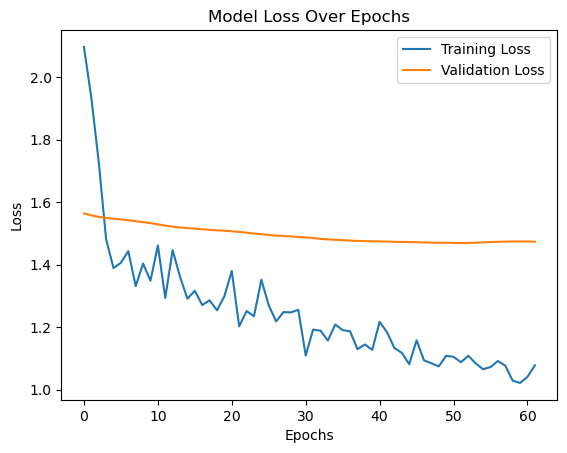

In [82]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Random Search with 2 Layers

In [107]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid for random hyperparameter search.
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],               # Dropout rate for regularization.
    'recurrent_dropout': [0.1, 0.2],               # Recurrent dropout within LSTM layers.
    'l2_lambda': [0.001, 0.01, 0.1],               # L2 regularization strength.
    'learning_rate': [0.001, 0.0005, 0.0001],      # Learning rate for optimizer.
    'learning_rate_decay': [1e-6, 1e-5, 0],        # Decay rate for learning rate over time.
    'units1': [32, 64, 128],                       # Number of units in the first LSTM layer.
    'units2': [32, 64, 128],                       # Number of units in the second LSTM layer.
    'batch_size': [32, 64, 120, 256],              # Batch size for training.
    'epochs': [50, 100, 200],                      # Number of epochs to train.
    'optimizer': ['adam'],                         # Optimizer to use.
    'clipnorm': [1.0, 5.0]                         # Gradient clipping to avoid exploding gradients.
}

# Generate a list of random combinations of hyperparameters.
n_iter_search = 30  # Number of random combinations to attempt.
# Random state being applied for reproducibility. 
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42)) 

# Define a function to build the LSTM model with given parameters.
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, optimizer_name, loss_function):
    model = Sequential()
    
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape based on sequence data.
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())  # Batch normalization for stable training.
    model.add(Dropout(dropout_rate))  # Dropout for regularization.
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units2, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer with a single unit for regression output.
    model.add(Dense(1))
    
    # Select optimizer with learning rate decay and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile the model with the chosen optimizer and loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Define early stopping to stop training when validation loss does not improve.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to store results of each model configuration.
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.01, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 5.0, 'batch_size': 64}
Final Training Loss: 1.5383754968643188
Final Validation Loss: 1.755383014678955
Running combination 2/30: {'units2': 128, 'units1': 64, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.001, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 1.9409369230270386
Final Validation Loss: 1.9975848197937012
Running combination 3/30: {'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 1.0, 'batch_size': 64}
Final Training Loss: 1.570006012916565
Final Validation Loss: 1.6737358570098877
Running combination 4/

In [259]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 64,
    'units2': 32,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-06,
    'learning_rate': 0.001,
    'l2_lambda': 0.001,
    'epochs': 200,
    'dropout_rate': 0.3,
    'clipnorm': 1.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=False, 
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 2.8442 - val_loss: 1.3627
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.2601 - val_loss: 1.3592
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9699 - val_loss: 1.3536
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8142 - val_loss: 1.3452
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7891 - val_loss: 1.3490
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6776 - val_loss: 1.3354
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.5718 - val_loss: 1.3432
Epoch 8/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.4091 - val_loss: 1.3374
Epoch 9/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3981 - val_loss: 1.3537
Epoch 10/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4074 - val_loss: 1.3186
Epoch 11/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3812 - val_loss: 1.3128
Epoch 12/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
LSTM Model Performance:
Training RMSE: 0.013250822903037328
Test RMSE: 0.01498376587661119
Training MAE: 0.009554230024764042
Test MAE: 0.01125901170404252
Directional Accuracy on Training Data: 58.019525801952575%
Directional Accuracy on Test Data: 69.52380952380952%


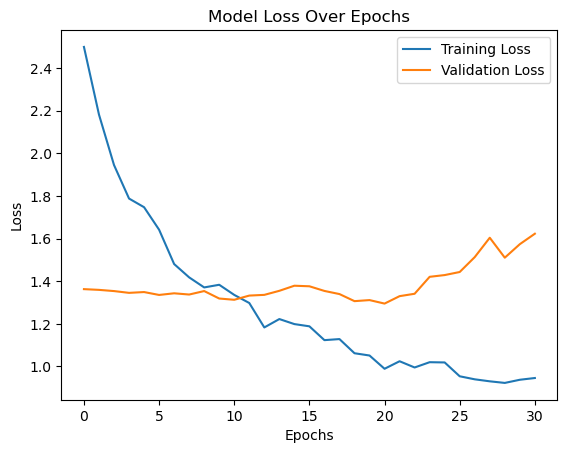

In [260]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Random Search with 3 Layers

In [108]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],
    'recurrent_dropout': [0.1, 0.2],
    'l2_lambda': [0.001, 0.01, 0.1],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'learning_rate_decay': [1e-6, 1e-5, 0],
    'units1': [32, 64, 128],
    'units2': [32, 64, 128],
    'units3': [32, 64, 128],
    'batch_size': [32, 64, 120, 256],  
    'epochs': [50, 100, 200],
    'optimizer': ['adam'],
    'clipnorm': [1.0, 5.0]
}

# Generate a list of random combinations with ParameterSampler
n_iter_search = 30
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42))

# Define the function to build the model with variable parameters
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, units3, optimizer_name, loss_function):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units2, return_sequences=True, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units3, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer.
    model.add(Dense(1))
    
    # Select optimizer with decay and clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to keep track of results
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        units3=params['units3'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        shuffle=False,
        callbacks=[early_stopping],
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units3': 32, 'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 5.0, 'batch_size': 32}
Final Training Loss: 1.1681524515151978
Final Validation Loss: 1.7008633613586426
Running combination 2/30: {'units3': 128, 'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0001, 'l2_lambda': 0.01, 'epochs': 50, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 4.065481662750244
Final Validation Loss: 3.979375123977661
Running combination 3/30: {'units3': 128, 'units2': 64, 'units1': 64, 'recurrent_dropout': 0.1, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.4, 'clipnorm': 5.0, 'batch_size': 256}
Final Training Loss: 2.197089910507202
Final Validat

In [109]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'units2': 32,
    'units3': 32,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.0005,
    'l2_lambda': 0.001,
    'epochs': 100,
    'dropout_rate': 0.4,
    'clipnorm': 1.0,
    'batch_size': 120
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))

        # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units3'], return_sequences=False, 
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - loss: 4.4799 - val_loss: 1.5930
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 4.0713 - val_loss: 1.5938
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 3.8442 - val_loss: 1.5962
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 3.5873 - val_loss: 1.5989
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 3.2489 - val_loss: 1.6003
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 3.0561 - val_loss: 1.6012
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 2.9118 - val_loss: 1.5983
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 2.8907 - val_loss: 1.5954
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 2.9801 - val_loss: 1.5914
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 2.4383 - val_loss: 1.5893
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 2.7420 - val_loss: 1.5878
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 2.5803 - val_l

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
LSTM Model Performance:
Training RMSE: 0.012848620016906091
Test RMSE: 0.014870232829350797
Training MAE: 0.00933963270228803
Test MAE: 0.010996235527122294
Directional Accuracy on Training Data: 59.41422594142259%
Directional Accuracy on Test Data: 57.14285714285714%


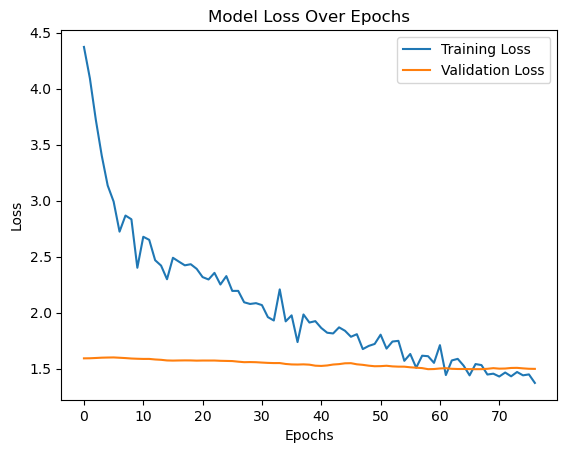

In [110]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [113]:
# Extract scaled train and validation loss from history
scaled_train_loss = history.history['loss'][-1]  # Final train loss
scaled_val_loss = history.history['val_loss'][-1]  # Final validation loss

# Descale train and validation losses using the `scaler`
descaled_train_loss = np.sqrt(scaled_train_loss) * scaler.scale_[0] + scaler.mean_[0]
descaled_val_loss = np.sqrt(scaled_val_loss) * scaler.scale_[0] + scaler.mean_[0]

# Print the descaled losses
print(f"Descaled Training Loss: {descaled_train_loss}")
print(f"Descaled Validation Loss: {descaled_val_loss}")

Descaled Training Loss: 0.015503462718846476
Descaled Validation Loss: 0.016178040952116765


### Model Performance Comparison (Sequence Length = 26)

| **Metric**            | **Random Search (Optuna)** | **Keras Tuner**       | **Random Search (2 Layers)** | **Random Search (3 Layers)** |
|------------------------|---------------------------|-----------------------|-----------------------------|-----------------------------|
| **Train RMSE**         | 0.01293746               | 0.01299757            | 0.01325082                  | 0.01284862                  |
| **Test RMSE**          | 0.01509611               | 0.01542304            | 0.01498377                  | 0.01487023                  |
| **Train MAE**          | 0.00940679               | 0.00950083            | 0.00955423                  | 0.00933963                  |
| **Test MAE**           | 0.01132248               | 0.01176975            | 0.01125901                  | 0.01099624                  |
| **Train Loss**         | 0.95640093               | 1.07758844            | 0.94595361                  | 1.37365758                  |
| **Validation Loss**    | 1.86867500               | 1.47335637            | 1.62249756                  | 1.49907696                  |
| **Train DA**           | 72.11%                   | 73.22%                | 58.02%                      | 59.41%                      |
| **Test DA**            | 72.38%                   | 72.38%                | 69.52%                      | 57.14%                      |

- The model that achieved the best score metrics was searching the parameters using random search (3 layers). Yielding lower RMSE and MAE. In addition, in the train and val loss shows the first decreases over time, but not that stable. The second, it does not increase, but it plateau.
  
### Cross Validation with the best model with descaled metrics. 

#### **Training and Validation Loss**
| **Metric**           | **Loss**          |
|-----------------------|-------------------|
| **Training Loss**     | 0.01550346        |
| **Validation Loss**   | 0.01617804        |


#### **TSCV RMSE Values**
| **Fold** | **RMSE**         |
|----------|------------------|
| 1        | 0.01985760       |
| 2        | 0.01436684       |
| 3        | 0.01137710       |
| 4        | 0.00883846       |

**Average TSCV RMSE**: **0.01361000**

- Same as the previous wheres the model enhance its performance in later folds. 

#### **FRWCV RMSE Values**
| **Window** | **RMSE**         |
|------------|------------------|
| 1          | 0.01577528       |
| 2          | 0.01113802       |
| 3          | 0.01195426       |
| 4          | 0.00778793       |

**Average FRWCV RMSE**: **0.01166387**

- The behavious is similar to other SL, where the model adapts to new windows, but it performs better in later windows.

In [115]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'units2': 32,
    'units3': 32,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.0005,
    'l2_lambda': 0.001,
    'epochs': 100,
    'dropout_rate': 0.4,
    'clipnorm': 1.0,
    'batch_size': 120
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))

        # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units3'], return_sequences=False, 
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    optimizer = Adam(learning_rate=params['learning_rate'], 
                     decay=params['learning_rate_decay'], 
                     clipnorm=params['clipnorm'])
    
    # Compile the model
    model.compile(optimizer=optimizer, loss=params['loss_function'])
    
    return model

# Define the number of splits for Time Series Cross-Validation
n_splits = 4
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize the list to store RMSE scores
tscv_rmse_scores = []

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Create the model once and save its initial weights
model = build_best_model(best_params)
initial_weights = model.get_weights()

# Perform TSCV
for fold, (train_index, test_index) in enumerate(tscv.split(y_train_scaled)):
    print(f"Fold {fold + 1}")

    # Reset model to initial weights
    model.set_weights(initial_weights)
    
    # Define train and test sets
    y_train_fold, y_test_fold = y_train_scaled[train_index], y_train_scaled[test_index]
    
    # Create sequences for TSCV
    X_train_seq, y_train_seq = [], []
    for i in range(len(y_train_fold) - sequence_length):
        X_train_seq.append(y_train_fold[i:i + sequence_length])  # Sequence of past residuals.
        y_train_seq.append(y_train_fold[i + sequence_length])    # Next residual value as target.
    
    X_test_seq, y_test_seq = [], []
    for i in range(len(y_test_fold) - sequence_length):
        X_test_seq.append(y_test_fold[i:i + sequence_length])  # Sequence of past residuals.
        y_test_seq.append(y_test_fold[i + sequence_length])    # Next residual value as target.
    
    # Convert to numpy arrays
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size'],
        validation_data=(X_test_seq, y_test_seq),
        shuffle=False,
        verbose=0,
        callbacks=[early_stopping]
    )
    
    # Predict and evaluate
    y_pred = model.predict(X_test_seq)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    tscv_rmse_scores.append(rmse)
    print(f"Fold {fold + 1} RMSE: {rmse}")

# Calculate the average RMSE across all folds
avg_rmse = np.mean(tscv_rmse_scores)
print(f"Average RMSE from TSCV: {avg_rmse}")

Fold 1
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step
Fold 1 RMSE: 1.5098432939410076
Fold 2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Fold 2 RMSE: 1.0838477674033467
Fold 3
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Fold 3 RMSE: 0.8518907783600195
Fold 4
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Fold 4 RMSE: 0.6549327019187772
Average RMSE from TSCV: 1.0251286354057878


In [116]:
# Parameters for FRWCV
train_window = 300  # Training window size
test_window = 100    # Test window size

# Store RMSEs for each window
rolling_rmse_scores = []

for start in range(0, len(y_train_scaled) - train_window - test_window, test_window):
    print(f"Rolling window starting at index {start}")
    
    # Define train and test sets for the window
    y_train_fold = y_train_scaled[start:start + train_window]
    y_test_fold = y_train_scaled[start + train_window:start + train_window + test_window]
    
    # Create sequences for FRWCV
    X_train_seq, y_train_seq = [], []
    for i in range(len(y_train_fold) - sequence_length):
        X_train_seq.append(y_train_fold[i:i + sequence_length])  # Sequence of past residuals.
        y_train_seq.append(y_train_fold[i + sequence_length])    # Next residual value as target.
    
    X_test_seq, y_test_seq = [], []
    for i in range(len(y_test_fold) - sequence_length):
        X_test_seq.append(y_test_fold[i:i + sequence_length])  # Sequence of past residuals.
        y_test_seq.append(y_test_fold[i + sequence_length])    # Next residual value as target.
    
    # Convert to numpy arrays
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)
    
    # Train the model
    model.set_weights(initial_weights)  # Reset to initial weights
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=best_params['epochs'], 
        batch_size=best_params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        shuffle=False,
        verbose=0,  # Suppress training logs for brevity
        callbacks=[early_stopping]
    )
    
    # Evaluate on the test set
    y_pred = model.predict(X_test_seq)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    rolling_rmse_scores.append(rmse)
    print(f"Rolling window RMSE: {rmse}")

# Calculate average RMSE across rolling windows
avg_rolling_rmse = np.mean(rolling_rmse_scores)
print(f"Average Rolling Window RMSE: {avg_rolling_rmse}")

Rolling window starting at index 0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Rolling window RMSE: 1.1931201785875876
Rolling window starting at index 100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Rolling window RMSE: 0.8333422800806657
Rolling window starting at index 200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Rolling window RMSE: 0.8966696000076902
Rolling window starting at index 300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Rolling window RMSE: 0.5734283546076059
Average Rolling Window RMSE: 0.8741401033208873


In [117]:
# Function to descale RMSE
def descale_rmse(scaled_rmse, scaler):
    # Reshape RMSE value to fit scaler requirements
    scaled_rmse_array = np.array(scaled_rmse).reshape(-1, 1)
    # Inverse transform the RMSE
    descaled_rmse_array = scaler.inverse_transform(scaled_rmse_array)
    # Return the descaled RMSE as a list
    return descaled_rmse_array.flatten().tolist()

# Descale TSCV RMSE values
descaled_tscv_rmse = descale_rmse(tscv_rmse_scores, scaler)
print("Descaled TSCV RMSE Values:", descaled_tscv_rmse)

# Descale FRWCV RMSE values
descaled_frwcv_rmse = descale_rmse(rolling_rmse_scores, scaler)
print("Descaled FRWCV RMSE Values:", descaled_frwcv_rmse)

# Calculates average descaled RMSE
average_tscv_rmse = np.mean(descaled_tscv_rmse)
average_frwcv_rmse = np.mean(descaled_frwcv_rmse)
print(f"Average Descaled TSCV RMSE: {average_tscv_rmse}")
print(f"Average Descaled FRWCV RMSE: {average_frwcv_rmse}")

Descaled TSCV RMSE Values: [0.019857597061216658, 0.014366843946918034, 0.011377097621822804, 0.008838460231905494]
Descaled FRWCV RMSE Values: [0.015775280877918876, 0.01113802181386612, 0.01195426202637632, 0.007787932184193411]
Average Descaled TSCV RMSE: 0.013609999715465749
Average Descaled FRWCV RMSE: 0.01166387422558868


## Sequence Length = 52

In [198]:
# Reshape residual data into sequences for LSTM.
sequence_length = 52  # Number of time steps used for target prediction.

# Initialize empty lists for the training set.
X_train_seq, y_train_seq = [], []
# Loop through the scaled training residuals to create sequences and targets.
for i in range(len(y_train_scaled) - sequence_length):
    X_train_seq.append(y_train_scaled[i:i + sequence_length])  # Sequence of past residuals.
    y_train_seq.append(y_train_scaled[i + sequence_length])    # Next residual value as target.

# Initialize empty lists for the test set.
X_test_seq, y_test_seq = [], []
# Loop through the scaled test residuals to create sequences and targets.
for i in range(len(y_test_scaled) - sequence_length):
    X_test_seq.append(y_test_scaled[i:i + sequence_length])  # Sequence of past residuals.
    y_test_seq.append(y_test_scaled[i + sequence_length])    # Next residual value as target.

# Convert lists to numpy arrays to use in LSTM model.
X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)

# Print the reshaped input and target data shapes for verification.
print(f"Reshaped X_train_seq shape: {X_train_seq.shape}") 
print(f"Reshaped y_train_seq shape: {y_train_seq.shape}") 
print(f"Reshaped X_test_seq shape: {X_test_seq.shape}")    
print(f"Reshaped y_test_seq shape: {y_test_seq.shape}")  

Reshaped X_train_seq shape: (692, 52, 1)
Reshaped y_train_seq shape: (692, 1)
Reshaped X_test_seq shape: (80, 52, 1)
Reshaped y_test_seq shape: (80, 1)


### Random Search with Optuna

In [110]:
# Set global random state for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Optuna's TPESampler with a fixed random seed for reproducibility in parameter search.
sampler = TPESampler(seed=random_seed)

# Create an Optuna study with direction "minimize" to minimize the validation loss.
study = optuna.create_study(direction="minimize", sampler=sampler)

# Define the objective function for hyperparameter optimization.
def lstm_objective(trial):
    """
    Objective function for Optuna to optimize hyperparameters of a LSTM model.
    This version uses residuals only, without additional features.
    """

    # Define hyperparameters to tune.
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.4, step=0.1)  # Dropout rate for LSTM layers.
    recurrent_dropout = trial.suggest_categorical("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout rate.
    l2_lambda = trial.suggest_loguniform("l2_lambda", 1e-3, 1e-1)  # L2 regularization factor.
    learning_rate = trial.suggest_categorical("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate for the optimizer.
    learning_rate_decay = trial.suggest_categorical("learning_rate_decay", [1e-6, 1e-5, 0])  # Learning rate decay.
    clipnorm = trial.suggest_categorical("clipnorm", [1.0, 5.0])  # Gradient clipping norm.
    units = trial.suggest_categorical("units", [32, 64, 128])  # Number of units in LSTM layers.
    num_layers = trial.suggest_int("num_layers", 1, 3)  # Number of LSTM layers.
    epochs = trial.suggest_int("epochs", 50, 200, step=50)  # Number of epochs.
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 120, 256])  # Batch size.

    # Initialize the Sequential model.
    model = Sequential()

    # Add LSTM layers based on num_layers.
    for i in range(num_layers):
        # Set return_sequences=True for all but the last LSTM layer.
        return_sequences = (i < num_layers - 1)
        
        # Add LSTM layer with specified hyperparameters.
        model.add(LSTM(
            units=units,
            return_sequences=return_sequences,
            input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,  # Input shape only for the first layer.
            kernel_regularizer=l2(l2_lambda),
            recurrent_dropout=recurrent_dropout
        ))

        # Add BatchNormalization and Dropout after each LSTM layer.
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    # Add the output layer with a single unit (regression).
    model.add(Dense(1))

    # Initialize the optimizer with learning rate, decay, and gradient clipping norm.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)

    # Compile the model with mean squared error loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Early stopping callback to avoid overfitting.
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model with given hyperparameters.
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test_seq, y_test_seq),
        shuffle=False,
        callbacks=[early_stopping],
        verbose=0  # Set verbose=0 to suppress training logs for faster experimentation.
    )

    # Retrieve the minimum validation loss from the training history.
    val_loss = min(history.history['val_loss'])
    
    # Return the validation loss to be minimized by Optuna.
    return val_loss

# Run the Optuna study for a given number of trials.
study.optimize(lstm_objective, n_trials=30)

# Print the best parameters found by the study.
print("Best hyperparameters:", study.best_params)

# Print the best validation loss achieved with the optimal parameters.
print("Best validation loss:", study.best_value)

[I 2024-11-26 15:38:10,986] A new study created in memory with name: no-name-4bed3956-e90a-4480-baf2-7a24cf1046cf
[I 2024-11-26 15:38:33,176] Trial 0 finished with value: 1.916581630706787 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.0037550037026405905, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 3, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 1.916581630706787.
[I 2024-11-26 15:38:42,988] Trial 1 finished with value: 3.9373021125793457 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.04641587067816149, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 2, 'epochs': 50, 'batch_size': 256}. Best is trial 0 with value: 1.916581630706787.
[I 2024-11-26 15:39:34,563] Trial 2 finished with value: 4.456530570983887 and parameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0.2, 

Best hyperparameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0.1, 'l2_lambda': 0.005593134253013597, 'learning_rate': 0.001, 'learning_rate_decay': 1e-05, 'clipnorm': 5.0, 'units': 32, 'num_layers': 1, 'epochs': 100, 'batch_size': 64}
Best validation loss: 1.4284842014312744


In [291]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.001,
    'l2_lambda': 0.005593134253013597,
    'epochs': 100,
    'dropout_rate': 0.4,
    'clipnorm': 1.0,
    'batch_size': 64
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 2.0695 - val_loss: 1.6596
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.4932 - val_loss: 1.6423
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.3732 - val_loss: 1.6413
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.3118 - val_loss: 1.6440
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.4123 - val_loss: 1.6492
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.3228 - val_loss: 1.6543
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2112 - val_loss: 1.6571
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2445 - val_loss: 1.6609
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2693 - val_loss: 1.6603
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2271 - val_loss: 1.6602
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1196 - val_loss: 1.6613
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - 

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
LSTM Model Performance:
Training RMSE: 0.013096241510752796
Test RMSE: 0.01673761054791326
Training MAE: 0.009490861790393235
Test MAE: 0.01264446669629161
Directional Accuracy on Training Data: 72.50361794500724%
Directional Accuracy on Test Data: 73.41772151898735%


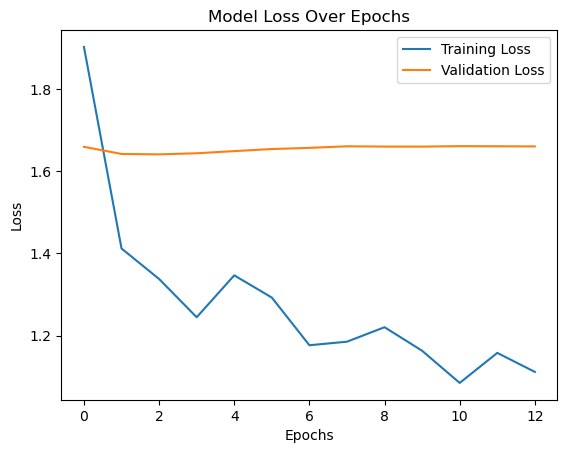

In [292]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Keras Tuner

In [111]:
# Set a global random seed for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Build LSTM model function with hyperparameter choices.
def build_lstm_model_tuner(hp):
    """
    Build an LSTM model for KerasTuner to optimize. Uses only residual sequences for input.
    """

    model = Sequential()

    # Define hyperparameters using `hp` for tuning options.
    dropout_rate = hp.Choice("dropout_rate", [0.2, 0.3, 0.4])  # Dropout rates.
    recurrent_dropout = hp.Choice("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout.
    l2_lambda = hp.Float("l2_lambda", min_value=0.001, max_value=0.1, sampling="log")  # L2 regularization.
    learning_rate = hp.Choice("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate.
    learning_rate_decay = hp.Choice("learning_rate_decay", [1e-5, 0.0])  # Learning rate decay.
    clipnorm = hp.Choice("clipnorm", [1.0, 5.0])  # Gradient clipping norm.
    units = hp.Choice("units", [32, 64, 128])  # Number of units in LSTM layers.
    num_layers = hp.Int("num_layers", 1, 3)  # Number of LSTM layers.
    batch_size = hp.Choice("batch_size", [32, 64, 120, 256])  # Batch size.

    # Add LSTM layers based on the number of layers selected.
    for i in range(num_layers):
        return_sequences = (i < num_layers - 1)  # Return sequences for intermediate layers only.
        model.add(LSTM(
            units=units,
            return_sequences=return_sequences,
            input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,
            kernel_regularizer=l2(l2_lambda),
            recurrent_dropout=recurrent_dropout
        ))
        model.add(BatchNormalization())  # Batch normalization to stabilize training.
        model.add(Dropout(dropout_rate))  # Dropout to combat overfitting.

    # Add the output layer (regression).
    model.add(Dense(1))

    # Configure optimizer with learning rate, decay, and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)

    # Compile the model.
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Print hyperparameters for debugging.
    print(f"Built model with params: dropout_rate={dropout_rate}, recurrent_dropout={recurrent_dropout}, "
          f"l2_lambda={l2_lambda}, learning_rate={learning_rate}, learning_rate_decay={learning_rate_decay}, "
          f"clipnorm={clipnorm}, units={units}, num_layers={num_layers}, batch_size={batch_size}")

    return model


# Set up Bayesian Optimization tuner to search for optimal hyperparameters.
tuner = BayesianOptimization(
    build_lstm_model_tuner,  # Model-building function.
    objective="val_loss",  # Target metric for optimization.
    max_trials=30,  # Maximum number of trials to run.
    executions_per_trial=1,  # Number of executions per trial.
    directory="sarimax-lstm",  # Directory to store tuning results.
    project_name="sarimax-lstm",  # Project name for the tuner.
    overwrite=True  # Overwrite previous tuner results if they exist.
)

# Define early stopping to prevent overfitting.
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Perform the hyperparameter search using the residuals (no features).
tuner.search(
    X_train_seq, y_train_seq,  # Training sequences and targets.
    validation_data=(X_test_seq, y_test_seq),  # Validation sequences and targets.
    epochs=200,  # Max number of epochs for each trial.
    callbacks=[early_stopping],  # Early stopping to avoid overfitting.
    shuffle=False,  # Ensure the time series order is preserved.
    verbose=1  # Show progress for each trial.
)

# Retrieve the best model and hyperparameters from the tuner.
best_lstm_model = tuner.get_best_models(num_models=1)[0]
best_lstm_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters found by KerasTuner.
print("Best hyperparameters for LSTM:", best_lstm_hyperparameters.values)
print("Best batch size for LSTM:", best_lstm_hyperparameters.get("batch_size"))

Trial 30 Complete [00h 00m 07s]
val_loss: 1.6257901191711426

Best val_loss So Far: 1.460659384727478
Total elapsed time: 00h 10m 32s
Built model with params: dropout_rate=0.4, recurrent_dropout=0.1, l2_lambda=0.002638473543668802, learning_rate=0.0005, learning_rate_decay=1e-05, clipnorm=1.0, units=32, num_layers=1, batch_size=64
Best hyperparameters for LSTM: {'dropout_rate': 0.4, 'recurrent_dropout': 0.1, 'l2_lambda': 0.002638473543668802, 'learning_rate': 0.0005, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 1, 'batch_size': 64}
Best batch size for LSTM: 64


In [200]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.0005,
    'l2_lambda': 0.002638473543668802,
    'epochs': 200,
    'dropout_rate': 0.4,
    'clipnorm': 1.0,
    'batch_size': 64
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 2.1871 - val_loss: 1.6660
Epoch 2/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7194 - val_loss: 1.6511
Epoch 3/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4580 - val_loss: 1.6422
Epoch 4/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3891 - val_loss: 1.6377
Epoch 5/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4809 - val_loss: 1.6387
Epoch 6/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4094 - val_loss: 1.6424
Epoch 7/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2899 - val_loss: 1.6446
Epoch 8/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3377 - val_loss: 1.6464
Epoch 9/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3831 - val_loss: 1.6463
Epoch 10/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3569 - val_loss: 1.6471
Epoch 11/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2284 - val_loss: 1.6482
Epoch 12/200
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
LSTM Model Performance:
Training RMSE: 0.013101054608967166
Test RMSE: 0.016737222218403895
Training MAE: 0.009491826698625864
Test MAE: 0.012637349111161263
Directional Accuracy on Training Data: 72.50361794500724%
Directional Accuracy on Test Data: 72.15189873417721%


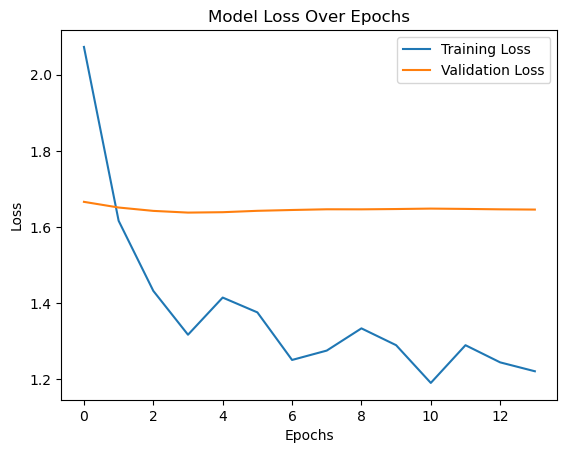

In [201]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Random Search with 2 Layers

In [112]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid for random hyperparameter search.
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],               # Dropout rate for regularization.
    'recurrent_dropout': [0.1, 0.2],               # Recurrent dropout within LSTM layers.
    'l2_lambda': [0.001, 0.01, 0.1],               # L2 regularization strength.
    'learning_rate': [0.001, 0.0005, 0.0001],      # Learning rate for optimizer.
    'learning_rate_decay': [1e-6, 1e-5, 0],        # Decay rate for learning rate over time.
    'units1': [32, 64, 128],                       # Number of units in the first LSTM layer.
    'units2': [32, 64, 128],                       # Number of units in the second LSTM layer.
    'batch_size': [32, 64, 120, 256],              # Batch size for training.
    'epochs': [50, 100, 200],                      # Number of epochs to train.
    'optimizer': ['adam'],                         # Optimizer to use.
    'clipnorm': [1.0, 5.0]                         # Gradient clipping to avoid exploding gradients.
}

# Generate a list of random combinations of hyperparameters.
n_iter_search = 30  # Number of random combinations to attempt.
# Random state being applied for reproducibility. 
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42)) 

# Define a function to build the LSTM model with given parameters.
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, optimizer_name, loss_function):
    model = Sequential()
    
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape based on sequence data.
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())  # Batch normalization for stable training.
    model.add(Dropout(dropout_rate))  # Dropout for regularization.
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units2, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer with a single unit for regression output.
    model.add(Dense(1))
    
    # Select optimizer with learning rate decay and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile the model with the chosen optimizer and loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Define early stopping to stop training when validation loss does not improve.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to store results of each model configuration.
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.01, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 5.0, 'batch_size': 64}
Final Training Loss: 1.4820270538330078
Final Validation Loss: 1.8712801933288574
Running combination 2/30: {'units2': 128, 'units1': 64, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.001, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 2.0711400508880615
Final Validation Loss: 2.430020809173584
Running combination 3/30: {'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 1.0, 'batch_size': 64}
Final Training Loss: 1.8248932361602783
Final Validation Loss: 1.8408236503601074
Running combination 4

In [320]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 64,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.001,
    'l2_lambda': 0.001,
    'epochs': 200,
    'dropout_rate': 0.3,
    'clipnorm': 1.0,
    'batch_size': 256
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=False, 
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 219ms/step - loss: 4.7995 - val_loss: 1.7553
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 3.3800 - val_loss: 1.7592
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 2.7200 - val_loss: 1.7593
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 2.2447 - val_loss: 1.7616
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 2.3390 - val_loss: 1.7629
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 2.1100 - val_loss: 1.7628
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 2.1620 - val_loss: 1.7619
Epoch 8/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.9281 - val_loss: 1.7609
Epoch 9/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.9034 - val_loss: 1.7598
Epoch 10/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 1.7610 - val_loss: 1.7578
Epoch 11/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 1.9129 - val_loss: 1.7564
Final Training Loss: 1.7220230102539062
Final Validation Loss: 1.75639331

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
LSTM Model Performance:
Training RMSE: 0.013134621449073527
Test RMSE: 0.016789743852631572
Training MAE: 0.009544190317659669
Test MAE: 0.01277682679612636
Directional Accuracy on Training Data: 65.41244573082489%
Directional Accuracy on Test Data: 64.55696202531645%


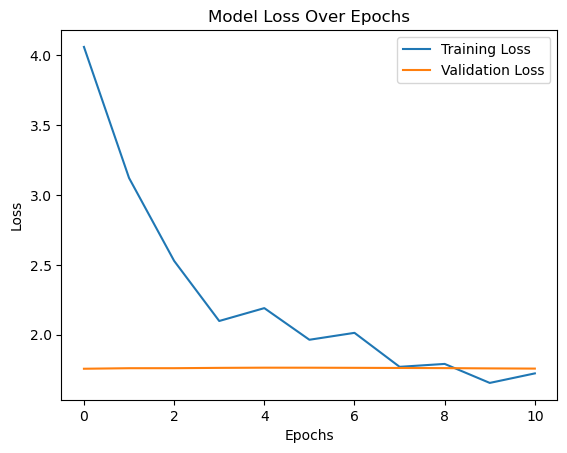

In [321]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Random Search with 3 Layers

In [113]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],
    'recurrent_dropout': [0.1, 0.2],
    'l2_lambda': [0.001, 0.01, 0.1],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'learning_rate_decay': [1e-6, 1e-5, 0],
    'units1': [32, 64, 128],
    'units2': [32, 64, 128],
    'units3': [32, 64, 128],
    'batch_size': [32, 64, 120, 256],  
    'epochs': [50, 100, 200],
    'optimizer': ['adam'],
    'clipnorm': [1.0, 5.0]
}

# Generate a list of random combinations with ParameterSampler
n_iter_search = 30
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42))

# Define the function to build the model with variable parameters
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, units3, optimizer_name, loss_function):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units2, return_sequences=True, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units3, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer.
    model.add(Dense(1))
    
    # Select optimizer with decay and clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to keep track of results
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        units3=params['units3'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        shuffle=False,
        callbacks=[early_stopping],
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units3': 32, 'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 5.0, 'batch_size': 32}
Final Training Loss: 1.0677937269210815
Final Validation Loss: 2.2250869274139404
Running combination 2/30: {'units3': 128, 'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0001, 'l2_lambda': 0.01, 'epochs': 50, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 4.05915641784668
Final Validation Loss: 4.346669673919678
Running combination 3/30: {'units3': 128, 'units2': 64, 'units1': 64, 'recurrent_dropout': 0.1, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.4, 'clipnorm': 5.0, 'batch_size': 256}
Final Training Loss: 2.5092999935150146
Final Validat

In [348]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'units2': 32,
    'units3': 32,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-06,
    'learning_rate': 0.001,
    'l2_lambda': 0.001,
    'epochs': 50,
    'dropout_rate': 0.4,
    'clipnorm': 1.0,
    'batch_size': 256
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))

        # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units3'], return_sequences=False, 
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 347ms/step - loss: 4.6664 - val_loss: 1.8662
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 3.6452 - val_loss: 1.8653
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 3.6665 - val_loss: 1.8624
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 3.5538 - val_loss: 1.8617
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 3.0840 - val_loss: 1.8630
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - loss: 3.3165 - val_loss: 1.8640
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 2.8294 - val_loss: 1.8643
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 3.0438 - val_loss: 1.8634
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 2.9553 - val_loss: 1.8607
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 2.7518 - val_loss: 1.8580
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 2.5515 - val_loss: 1.8554
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 2.8817 - val_lo

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
LSTM Model Performance:
Training RMSE: 0.013143053087386817
Test RMSE: 0.016674830259335187
Training MAE: 0.009508237340569419
Test MAE: 0.012545026415538642
Directional Accuracy on Training Data: 48.914616497829236%
Directional Accuracy on Test Data: 53.16455696202531%


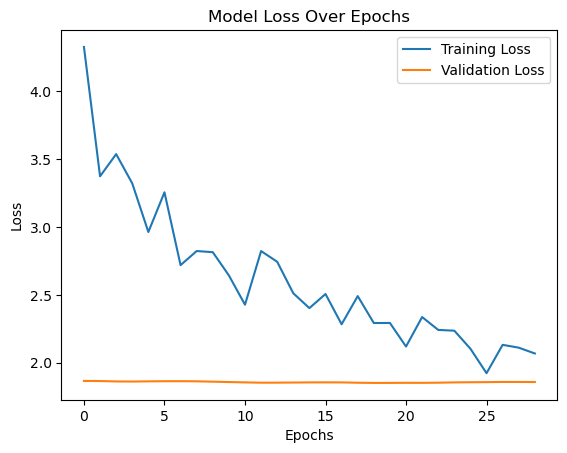

In [349]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [204]:
# Extract scaled train and validation loss from history
scaled_train_loss = history.history['loss'][-1]  # Final train loss
scaled_val_loss = history.history['val_loss'][-1]  # Final validation loss

# Descale train and validation losses using the `scaler`
descaled_train_loss = np.sqrt(scaled_train_loss) * scaler.scale_[0] + scaler.mean_[0]
descaled_val_loss = np.sqrt(scaled_val_loss) * scaler.scale_[0] + scaler.mean_[0]

# Print the descaled losses
print(f"Descaled Training Loss: {descaled_train_loss}")
print(f"Descaled Validation Loss: {descaled_val_loss}")


Descaled Training Loss: 0.014638241515476977
Descaled Validation Loss: 0.016931564367275234


### Model Performance Comparison (Sequence Length = 52)

| **Metric**            | **Random Search (Optuna)** | **Keras Tuner** | **Random Search (2 Layers)** | **Random Search (3 Layers)** |
|------------------------|---------------------------|-----------------|-----------------------------|-----------------------------|
| **Train RMSE**         | 0.01309624               | 0.01310105      | 0.01313462                  | 0.01314305                  |
| **Test RMSE**          | 0.01673761               | 0.01673722      | 0.01678974                  | 0.01667483                  |
| **Train MAE**          | 0.00949086               | 0.00949183      | 0.00954419                  | 0.00950824                  |
| **Test MAE**           | 0.01264447               | 0.01263735      | 0.01277683                  | 0.01254503                  |
| **Train Loss**         | 1.11143768               | 1.22081268      | 1.72202301                  | 2.06824327                  |
| **Validation Loss**    | 1.66066432               | 1.64565146      | 1.75639331                  | 1.85821283                  |
| **Train DA**           | 72.50%                   | 72.50%          | 65.41%                      | 48.91%                      |
| **Test DA**            | 73.42%                   | 72.15%          | 64.56%                      | 53.16%                      |

- All the four models had similar score metrics (RMSE and MAE) and to select the best model in the current sequence length secondary metrics sill come into play, the validation loss and DA from Keras Tuner parameters shows a more balanced model, with higher DA and lower val loss. 

### Cross Validation of the best model (Keras Tuner) with descaled metrics 

#### Training and Validation Loss
| **Metric**           | **Loss**        |
|-----------------------|-----------------|
| **Training Loss**     | 0.01463824      |
| **Validation Loss**   | 0.01693156      |

#### TSCV RMSE Values
| **Fold** | **RMSE**         |
|----------|------------------|
| **1**    | 0.02059443       |
| **2**    | 0.01438539       |
| **3**    | 0.01112995       |
| **4**    | 0.00895678       |

**Average TSCV RMSE**: **0.01376664**

- The TSCV shows that the behaviour of the model is similar to the SL 4, 12 and 26. However, it shows higher RMSE scores and indicating that the model make "higher" errors when sequence length is increased.  

#### FRWCV RMSE Values
| **Window** | **RMSE**         |
|------------|------------------|
| **1**      | 0.01674439       |
| **2**      | 0.01008440       |
| **3**      | 0.01231426       |
| **4**      | 0.00731960       |

**Average FRWCV RMSE**: **0.01161566**

- The model shows stability on the predictions on the 2,3 and 4 window, but it struggles at the first window. 


In [144]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.0005,
    'l2_lambda': 0.002638473543668802,
    'epochs': 200,
    'dropout_rate': 0.4,
    'clipnorm': 1.0,
    'batch_size': 64
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    optimizer = Adam(learning_rate=params['learning_rate'], 
                     decay=params['learning_rate_decay'], 
                     clipnorm=params['clipnorm'])
    
    # Compile the model
    model.compile(optimizer=optimizer, loss=params['loss_function'])
    
    return model

# Define the number of splits for Time Series Cross-Validation
n_splits = 4
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize the list to store RMSE scores
tscv_rmse_scores = []

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Create the model once and save its initial weights
model = build_best_model(best_params)
initial_weights = model.get_weights()

# Perform TSCV
for fold, (train_index, test_index) in enumerate(tscv.split(y_train_scaled)):
    print(f"Fold {fold + 1}")

    # Reset model to initial weights
    model.set_weights(initial_weights)
    
    # Define train and test sets
    y_train_fold, y_test_fold = y_train_scaled[train_index], y_train_scaled[test_index]
    
    # Create sequences for TSCV
    X_train_seq, y_train_seq = [], []
    for i in range(len(y_train_fold) - sequence_length):
        X_train_seq.append(y_train_fold[i:i + sequence_length])  # Sequence of past residuals.
        y_train_seq.append(y_train_fold[i + sequence_length])    # Next residual value as target.
    
    X_test_seq, y_test_seq = [], []
    for i in range(len(y_test_fold) - sequence_length):
        X_test_seq.append(y_test_fold[i:i + sequence_length])  # Sequence of past residuals.
        y_test_seq.append(y_test_fold[i + sequence_length])    # Next residual value as target.
    
    # Convert to numpy arrays
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size'],
        validation_data=(X_test_seq, y_test_seq),
        shuffle=False,
        verbose=0,
        callbacks=[early_stopping]
    )
    
    # Predict and evaluate
    y_pred = model.predict(X_test_seq)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    tscv_rmse_scores.append(rmse)
    print(f"Fold {fold + 1} RMSE: {rmse}")

# Calculate the average RMSE across all folds
avg_rmse = np.mean(tscv_rmse_scores)
print(f"Average RMSE from TSCV: {avg_rmse}")

Fold 1
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
Fold 1 RMSE: 1.567009617860865
Fold 2
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Fold 2 RMSE: 1.0852869882131284
Fold 3
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Fold 3 RMSE: 0.8327156675996834
Fold 4
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Fold 4 RMSE: 0.6641127895532446
Average RMSE from TSCV: 1.0372812658067303


In [145]:
# Parameters for FRWCV
train_window = 300  # Training window size
test_window = 100    # Test window size

# Store RMSEs for each window
rolling_rmse_scores = []

for start in range(0, len(y_train_scaled) - train_window - test_window, test_window):
    print(f"Rolling window starting at index {start}")
    
    # Define train and test sets for the window
    y_train_fold = y_train_scaled[start:start + train_window]
    y_test_fold = y_train_scaled[start + train_window:start + train_window + test_window]
    
    # Create sequences for FRWCV
    X_train_seq, y_train_seq = [], []
    for i in range(len(y_train_fold) - sequence_length):
        X_train_seq.append(y_train_fold[i:i + sequence_length])  # Sequence of past residuals.
        y_train_seq.append(y_train_fold[i + sequence_length])    # Next residual value as target.
    
    X_test_seq, y_test_seq = [], []
    for i in range(len(y_test_fold) - sequence_length):
        X_test_seq.append(y_test_fold[i:i + sequence_length])  # Sequence of past residuals.
        y_test_seq.append(y_test_fold[i + sequence_length])    # Next residual value as target.
    
    # Convert to numpy arrays
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)
    
    # Train the model
    model.set_weights(initial_weights)  # Reset to initial weights
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=best_params['epochs'], 
        batch_size=best_params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        shuffle=False,
        verbose=0,  # Suppress training logs for brevity
        callbacks=[early_stopping]
    )
    
    # Evaluate on the test set
    y_pred = model.predict(X_test_seq)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    rolling_rmse_scores.append(rmse)
    print(f"Rolling window RMSE: {rmse}")

# Calculate average RMSE across rolling windows
avg_rolling_rmse = np.mean(rolling_rmse_scores)
print(f"Average Rolling Window RMSE: {avg_rolling_rmse}")

Rolling window starting at index 0
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
Rolling window RMSE: 1.2683079516379434
Rolling window starting at index 100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
Rolling window RMSE: 0.7515977032035128
Rolling window starting at index 200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Rolling window RMSE: 0.9245999549376567
Rolling window starting at index 300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Rolling window RMSE: 0.5370929509082584
Average Rolling Window RMSE: 0.8703996401718428


In [146]:
# Function to descale RMSE
def descale_rmse(scaled_rmse, scaler):
    # Reshape RMSE value to fit scaler requirements
    scaled_rmse_array = np.array(scaled_rmse).reshape(-1, 1)
    # Inverse transform the RMSE
    descaled_rmse_array = scaler.inverse_transform(scaled_rmse_array)
    # Return the descaled RMSE as a list
    return descaled_rmse_array.flatten().tolist()

# Descale TSCV RMSE values
descaled_tscv_rmse = descale_rmse(tscv_rmse_scores, scaler)
print("Descaled TSCV RMSE Values:", descaled_tscv_rmse)

# Descale FRWCV RMSE values
descaled_frwcv_rmse = descale_rmse(rolling_rmse_scores, scaler)
print("Descaled FRWCV RMSE Values:", descaled_frwcv_rmse)

# Calculates average descaled RMSE
average_tscv_rmse = np.mean(descaled_tscv_rmse)
average_frwcv_rmse = np.mean(descaled_frwcv_rmse)
print(f"Average Descaled TSCV RMSE: {average_tscv_rmse}")
print(f"Average Descaled FRWCV RMSE: {average_frwcv_rmse}")

Descaled TSCV RMSE Values: [0.020594426796606405, 0.01438539439088091, 0.011129945263252136, 0.008956784466852667]
Descaled FRWCV RMSE Values: [0.01674439316505676, 0.010084397392705514, 0.012314262715964832, 0.007319596911654225]
Average Descaled TSCV RMSE: 0.01376663772939803
Average Descaled FRWCV RMSE: 0.011615662546345332


## Evaluation of optimal model for Standard Scaler 
- The next table will be composed by the best model for each sequence length. The technologies will be evaluated to decide which sequence length is the optimal for the model and scaler.

| **Sequence Length (SL)** | **Train RMSE** | **Test RMSE** | **Train MAE** | **Test MAE** | **Train DA** | **Test DA** | **Train Loss** | **Validation Loss** |
|---------------------------|----------------|---------------|---------------|--------------|--------------|-------------|----------------|---------------------|
| **4**                    | 0.01286139     | 0.01576479    | 0.00935142    | 0.01196766   | 64.41%       | 67.72%      | 0.01336961     | 0.01247102          |
| **12**                   | 0.01317320     | 0.01590546    | 0.00960840    | 0.01218864   | 57.05%       | 59.66%      | 0.01766732     | 0.01735590          |
| **26**                   | 0.01284862     | 0.01487023    | 0.00933963    | 0.01099624   | 59.41%       | 57.14%      | 0.01550346     | 0.01617804          |
| **52**                   | 0.01310105     | 0.01673722    | 0.00949183    | 0.01263735   | 72.50%       | 72.15%      | 0.01463824     | 0.01693156          |

### TSCV RMSE Comparison

| **Sequence Length (SL)** | **Fold 1 RMSE** | **Fold 2 RMSE** | **Fold 3 RMSE** | **Fold 4 RMSE** | **Average TSCV RMSE** | **Training Loss** | **Validation Loss** |
|---------------------------|-----------------|-----------------|-----------------|-----------------|------------------------|-------------------|---------------------|
| **SL = 4**               | 0.01883255      | 0.01487593      | 0.01078377      | 0.01013835      | **0.01365765**         | 0.01336961        | 0.01247102          |
| **SL = 12**              | 0.01920988      | 0.01511425      | 0.01102393      | 0.00999259      | **0.01383516**         | 0.01766732        | 0.01735590          |
| **SL = 26**              | 0.01985760      | 0.01436684      | 0.01137710      | 0.00883846      | **0.01361000**         | 0.01550346        | 0.01617804          |
| **SL = 52**              | 0.02059443      | 0.01438539      | 0.01112995      | 0.00895678      | **0.01376664**         | 0.01463824        | 0.01693156          |

---

### FRWCV RMSE Comparison

| **Sequence Length (SL)** | **Window 1 RMSE** | **Window 2 RMSE** | **Window 3 RMSE** | **Window 4 RMSE** | **Average FRWCV RMSE** |
|---------------------------|-------------------|-------------------|-------------------|-------------------|------------------------|
| **SL = 4**               | 0.01620921        | 0.01081760        | 0.01151396        | 0.00969436        | **0.01214340**         |
| **SL = 12**              | 0.01661797        | 0.01107657        | 0.01200523        | 0.00986717        | **0.01239173**         |
| **SL = 26**              | 0.01577528        | 0.01113802        | 0.01195426        | 0.00778793        | **0.01166387**         |
| **SL = 52**              | 0.01674439        | 0.01008440        | 0.01231426        | 0.00731960        | **0.01161566**         |

---

